Import relevant libraries

In [4]:
import cv2
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
import tqdm.notebook as tq
import warnings
import pathlib
warnings.filterwarnings("ignore")

Define the path of the video to be processed (do this manually by changing video_file_name):


In [11]:
# Name of video file:
video_file_name = 'white.avi'
path = pathlib.Path.cwd() / 'Images' / video_file_name

Define Functions:

In [12]:
def get_image_sequence(video_path):
  '''
  get_image_sequence creates a numpy array containing frames of an input video
  '''
  i = False  # i is an index that indicates whether the image data is initialized
  cap = cv2.VideoCapture(video_path)
  while cap.isOpened():
      ret, frame = cap.read()
      # if frame is read correctly ret is True
      if not ret:
          print("Can't receive frame (stream end?). Exiting ...")
          break
      gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      if not i:
        image = np.array([gray])  # initialize numpy array
        i = True
      else:
        image = np.insert(image, [-1], [gray], axis=0)  # append each frame to numpy array

      if cv2.waitKey(1) == ord('q'):
          break
  cap.release()
  cv2.destroyAllWindows()

  print(image.shape[0], 'frames of size (', image.shape[1], ',', image.shape[2], ') were placed in the array "image"')

  return image.astype(np.int16)


def get_derivatives(image, print=False):
  '''
  get_derivatives will return the image derivatives for the input frames. It will
  not calculate the derivative for the last frame (i.e. calling this function for
  frames 60-80 will return derivatives for frames 60-79)

  - image = image sequence
  - print = if True, will print select frames from image derivatives
  '''
  # Append a frame of zeros to the front of the image to get the first image derivative
  image = np.insert(image, [0], np.zeros(shape=(image.shape[1], image.shape[2])), axis=0)
  # Loop through the image set, updating the derivative arrays at each time step
  for i in range(1, image.shape[0]):
    if i == 1:  # On the first pass, initialize the arrays
      I_t = [image[i,:,:] - image[0,:,:]]
      I_x = [cv2.Sobel(image[i,:,:], cv2.CV_64F, 1, 0, ksize=5)]  # The x derivative from a 5x5 Sobel filter
      I_y = [cv2.Sobel(image[i,:,:], cv2.CV_64F, 0, 1, ksize=5)]  # The y derivative from a 5x5 Sobel filter
    else:  # Afterwards, update
      I_t = np.insert(I_t, [-1], np.subtract(image[i,:,:], image[i-1,:,:]), axis=0)
      I_x = np.insert(I_x, [-1], [cv2.Sobel(image[i,:,:], cv2.CV_64F, 1, 0, ksize=5)], axis=0)
      I_y = np.insert(I_y, [-1], [cv2.Sobel(image[i,:,:], cv2.CV_64F, 0, 1, ksize=5)], axis=0)

  if print:
    plt.figure(figsize=(20,12))
    plt.subplot(2,3,1),plt.imshow(I_x[10,:,:],cmap = 'gray')
    plt.title('I_x, 10th frame')
    plt.subplot(2,3,2),plt.imshow(I_y[10,:,:],cmap = 'gray')
    plt.title('I_y, 10th frame')
    plt.subplot(2,3,3),plt.imshow(I_t[10,:,:],cmap = 'gray')
    plt.title('I_t, 10th frame')

    plt.subplot(2,3,4),plt.imshow(I_x[11,:,:],cmap = 'gray')
    plt.title('I_x, 11th frame')
    plt.subplot(2,3,5),plt.imshow(I_y[11,:,:],cmap = 'gray')
    plt.title('I_y, 11th frame')
    plt.subplot(2,3,6),plt.imshow(I_t[11,:,:],cmap = 'gray')
    plt.title('I_t, 11th frame');

  return I_x[:-1,:,:], I_y[:-1,:,:], I_t[:-1,:,:]


def get_windowed_image(image, frame, center, window, printed = False):
  '''
  get_windowed_image takes the image data and the frame of the image data as
  input and outputs a matrix of the frame windowed at the specified center.

  'window' is a square 2D numpy matrix representing a gaussian window.
  - image = image sequence held in numpy array
  - frame = the frame of the image data to window
  - center = center of the window
  - window = 2D matrix containing window (can use create_window to make)
  '''
  image_frame = image[frame, :, :]  # Single frame of the image data
  window_size = window.shape[0]     # Size of the window

  # An array of the same size as image_frame, with the window inserted into the correct spot
  window_mask = np.zeros(image_frame.shape)

  # The top corner of the edge to start inserting the window into window_mask
  edge_coordinate = (int(center[0] - window.shape[0]/2), int(center[1] - window.shape[0]/2))  
  slicer = tuple(slice(edge, edge+i) for edge, i in zip(edge_coordinate, window.shape))
  window_mask[slicer] = window  # Insert window into window_mask

  # Use window_mask to filter image_frame
  windowed_frame = np.multiply(image_frame, window_mask)
  
  if printed:
    plt.figure(figsize = (12,4))
    plt.subplot(1,3,1)
    plt.imshow(image_frame, cmap = 'gray'), plt.title('Image Frame')
    plt.subplot(1,3,2)
    plt.imshow(window_mask, cmap = 'gray'), plt.title('Window Mask')
    plt.subplot(1,3,3)
    plt.imshow(windowed_frame, cmap = 'gray'), plt.title('Windowed Frame')

  return windowed_frame


def create_window(size, sigma = 0.35, mu = 0):
  '''
  create_window returns a 2D gaussian window of the specified dimension

  - sigma = variance
  - mu = mean
  '''
  if size%2 != 0:
    raise NameError('Error: The size of the window must be even')

  x, y = np.meshgrid(np.linspace(-1,1,size), np.linspace(-1,1,size))
  d = np.sqrt(x*x+y*y)
  g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )

  # Normalize
  g = (g - np.min(g)) / (np.max(g) - np.min(g))
  return g


def window_sequence(images, window_center, window, print = False):
  '''
  window_sequence will take a sequence of images as input and output those images
  windowed through the Gaussian filter.

  - images = sequence of images
  - window_center = center of window in list format [y, x]
  - window = 2D Gaussian window
  '''
  windowed_images = np.zeros(images.shape)

  for i in range(images.shape[0]):
    windowed_images[i,:,:] = get_windowed_image(images, i, window_center, window, printed = print)
  
  return windowed_images



def get_points(frame, width, height, I_x, I_y, I_t, num_points=200, printed = False):
  '''
  get_points outputs a list of points that are interesting (i.e. will produce
  likelihood functions that aren't zero everywhere. 'points' is a frame of the
  same size as the image with the points of the coordinates being highlighted.
  If you plot points, it will show you which coordinates the function chose.

  - frame = frame of image derivative to get interesting points for
  - I_x, I_y, I_t = Image derivatives (can use get_derivatives function)
  - num_points = number of interesting points
  - print = if True, will show actual image point and relevant points
  '''
  I_x_neg = -I_x
  I_y_neg = -I_y
  I_t_neg = -I_t

  ix_max = I_x_neg[frame, :, :].flatten().argsort()[0:num_points]
  iy_max = I_y_neg[frame, :, :].flatten().argsort()[0:num_points]
  it_max = I_t_neg[frame, :, :].flatten().argsort()[0:num_points]

  coords, coords_x, coords_y = [], [], []
  for x, y, t in zip(ix_max, iy_max, it_max):
    c = np.unravel_index(x, I_x[frame,:,:].shape)
    coords.append(c)

    c = np.unravel_index(y, I_y[frame,:,:].shape)
    coords.append(c)

    c = np.unravel_index(t, I_t[frame,:,:].shape)
    coords.append(c)
  
  def eligible(coord):
    x, y = coord
    if (x > window_size) and (x < width - window_size):
      if (y > window_size) and (y < height - window_size):
        return True
    return False
  # The following code ensures the given points don't exceed the dimensions of the image
  slicer = []

  for ix, c in enumerate(coords):
    if eligible(c):
      slicer.append(ix)
    
  coords = [coords[ix] for ix in slicer]

  # Create points array
  points = np.zeros_like(I_x[frame,:,:])
  for c in coords:
    points[c[0], c[1]] = 100
  
  if printed:
    plt.figure(figsize = (12,4))
    #plt.imshow(image[int(image.shape[0]/2),:,:], cmap='gray')
    plt.imshow(image[frame_considered,:,:], cmap='gray')
    plt.title("Image with Sampled Points Overlayed")
    for c in coords:
      plt.plot(c[1], c[0], 'ro')
  return coords, points


def get_even_points(width, height, spacing, window_size, frame_considered, print = False):
  '''
  get_even_points produces evenly spaced coordinates

  - width = width of image
  - height = height of image
  - spacing = spacing between points
  - window_size = size of Gaussian window (in one dimension)
  - print = if True, will show actual image point and relevant points
  '''
  i = window_size/2
  j = window_size/2
  coords = []

  while i <= (width - window_size/2):
    j = window_size/2
    while j <= (height - window_size/2):
      coords.append((int(j), int(i)))
      j += spacing
    i += spacing
  
  # The following code ensures the given points don't exceed the dimensions of the image
  slicer = []
  for i in range(len(coords)):
    if (coords[i][0] <= (window_size/2)) | (coords[i][0] >= (height - window_size/2)):
      if (coords[i][1] <= (window_size/2)) | (coords[i][1] >= (width - window_size/2)):
        continue  
    else:
      slicer.append(i)
  coords = [coords[x] for x in slicer]  

  # Create points array
  points = np.zeros((height, width))
  for c in coords:
    points[c[0], c[1]] = 100

  if print:
    plt.figure(figsize = (12,4))
    #plt.imshow(image[int(image.shape[0]/2),:,:], cmap='gray')
    plt.imshow(image[frame_considered,:,:], cmap='gray')
    plt.title("Image with Sampled Points Overlayed")
    for c in coords:
      plt.plot(c[1], c[0], 'ro')

  return coords, points


def get_v_sum(coords, relative_frame, frame_considered, image, I_x, I_y, I_t, window, vx, vy, scaler, variance = 0.2, print_points = False, print_likelihoods = False, scale = False):
  '''
  get_v_sum returns the summed likelihoods from the image with windows centered 
  at all the points in coords

  - coords = list of coordinates
  - frame = frame of image derivative to use
  - I_x, I_y, I_t = image derivatives
  - window = 2D Gaussian window as numpy array
  - vx = [lower bound x velocity, upper bound x velocity]
  - vy = [lower bound y velocity, upper bound y velocity]
  - variance = variance implemented in probability equation
  - print_point = if True, will output a feed as the points are added to the sum
  - print_likelihoods = if True, will output an image of the component likelihoods
  '''
  velocity_sum = np.zeros((100, 100))
  sum_list = []
  for c in coords:
    filtered_I_x = window_sequence(I_x[:,:,:], list(c), window, print=False)
    filtered_I_y = window_sequence(I_y[:,:,:], list(c), window, print=False)
    filtered_I_t = window_sequence(I_t[:,:,:], list(c), window, print=False)
    window_center = list(c)
    sum, _ = get_likelihood(relative_frame, frame_considered, window_center, 
                            window.shape[0]/4, image, filtered_I_x, filtered_I_y, 
                            filtered_I_t, vx, vy, scaler, variance = variance, 
                            print = print_likelihoods, scale = scale)
    sum_list.append(sum)
    velocity_sum += sum
    if print_points:
      print('sum from point', c, 'added')

  return velocity_sum, sum_list


def plot_likelihood(l):
  '''
  plot_formatted plots a likelihood with formated axes and velocity highlighted
  '''

  velocity = np.unravel_index(l.argmax(), l.shape)

  plt.figure(figsize=(7,7))
  plt.imshow(l, cmap = 'gray');
  plt.vlines(l.shape[0]/2, 0, l.shape[0], colors='w')
  plt.hlines(l.shape[1]/2, 0,l.shape[1], colors='w')
  plt.plot(velocity[1], velocity[0], 'ro')
  plt.annotate(str(velocity), [velocity[1]+5, velocity[0]+5], size = 'large', color = 'r')


def get_posterior(prior, sum):
  return np.multiply(velocity_sum, g)


def get_sums_across_time(start=10, end=15, num_points=50):
  sums = []
  for frame in tq.tqdm(range(start, end)):
    coords = get_points(frame, num_points=num_points)
    sum = get_v_sum(coords)
    sums.append(sum)
  return sums


def feedback_prior(sums):
  prior = g
  change = []
  for ix in range(len(sums)):
    sum = sums[ix]
    posterior = get_posterior(prior, sum)
    change.append(posterior)
    prior = posterior
  return change


def gaussian_prior(sums):
  prior = g
  change = []
  for ix in range(len(sums)):
    sum = sums[ix]
    posterior = get_posterior(prior, sum)
    change.append(posterior)
  return change


def get_likelihood(relative_frame, frame_considered, window_center, window_size, image, I_x_w, I_y_w, I_t_w, vx, vy, scaler, variance = 0.2, print = False, scale = False):
  '''
  get_likelihood returns the likelihood across a windowed frame as sum and the 
  velocity of the point in velocity space that maximizes the likelihood. 

  - frame          :  the frame of the image sequence to get the likelihood for
  - window_center  :  [y,x] list corresponding to the center of the window
  - window_size    :  integer corresponding to size of window (This should be 100 for a 100x100 window)
  - I_x_w          :  I_x should already be windowed at window_center (get I_x first, then window)
  - I_y_w          :  I_y_w is windowed I_y, keep in mind I_y contains derivatives for multiple frames
  - I_t_w          :  windowed time derivative over multiple frames
  - vx             :  [lower bound of x velocity, upper bound of x velocity]
  - vy             :  [lower bound of y velocity, upper bound of y velocity]
  - variance       :  float corresponding to sigma in Eq. 4 from Weiss et. al
  - print          :  if true, the likelihood will be print as well as returned
  - scale          :  FOR TESTING. Scale should be false to get good results. Feel free to change it if
                      you want to experiment though 
  '''
  if scale:
    #scaler = MinMaxScaler(feature_range = (-1, 1))
    #scaler = StandardScaler(with_mean=False)
    I_x_w_10 = scaler.transform(I_x_w[relative_frame,:,:])  # I_<>_frame is the derivative for the specified frame
    I_y_w_10 = scaler.transform(I_y_w[relative_frame,:,:])

    time_scaler = MaxAbsScaler()
    I_t_w_10 = time_scaler.fit_transform(I_t_w[relative_frame,:,:])

  else:
    I_x_w_10 = I_x_w[relative_frame,:,:]  # I_<>_frame is the derivative for the specified frame
    I_y_w_10 = I_y_w[relative_frame,:,:]
    I_t_w_10 = I_t_w[relative_frame,:,:]

  # Create meshgrid to hold values
  nx, ny = (100, 100)                   # The number of points on the x and y axis
  vx = np.linspace(vx[0], vx[1], nx)    # x axis points (note these are flipped)
  vy = np.linspace(vy[0], vy[1], ny)    # y axis points
  u, v = np.meshgrid(vx, vy)            # u and v correspond to the velocity space

  # Coordinates of window centers and window size
  m = window_center[0]
  n = window_center[1]
  size = int(window_size/2)
  
  # variance
  var = variance

  p_scaler = MinMaxScaler(feature_range=(-100, -1))

  # We'll use (m,n), the pixel examined above, for this distribution
  sum = np.zeros((nx, ny))
  for x in range(m-size, m+size):   # Only compute the range of the window
    for y in range(n-size, n+size):
      p = -((I_x_w_10[x, y]*u + I_y_w_10[x, y]*v + I_t_w_10[x, y])**2)
      p = p/(2*(var**2))
      #p = p_scaler.fit_transform(p)
      #exp_p = np.exp(p)
      sum = np.add(sum, p)
      #sum = np.add(sum, exp_p)
  
  # Scale sum down
  scaler = MinMaxScaler(feature_range = (-100, -1))
  sum = scaler.fit_transform(sum)
  sum = np.exp(sum)
  velocity = np.unravel_index(sum.argmax(), sum.shape)

  if print:
    # Show the distribution
    plt.figure(figsize=(14,7))

    plt.subplot(1,2,1)
    plt.imshow(sum, cmap = 'gray');
    plt.vlines(nx/2, 0, ny, colors='w')
    plt.hlines(ny/2, 0, nx, colors='w')
    plt.plot(velocity[1], velocity[0], 'ro')
    plt.annotate(str(velocity), [velocity[1]+5, velocity[0]+5], size = 'large', color = 'r')
    title = 'Frame ' + str(frame_considered) + ' centered at (' + str(window_center) +')'
    plt.title(title)

    plt.subplot(1,2,2)
    plt.imshow(image[frame_considered,:,:], cmap='gray')
    plt.plot(window_center[1], window_center[0], 'ro')

  return sum, velocity

Get image sequence and derivatives:

Can't receive frame (stream end?). Exiting ...
150 frames of size ( 480 , 720 ) were placed in the array "image"


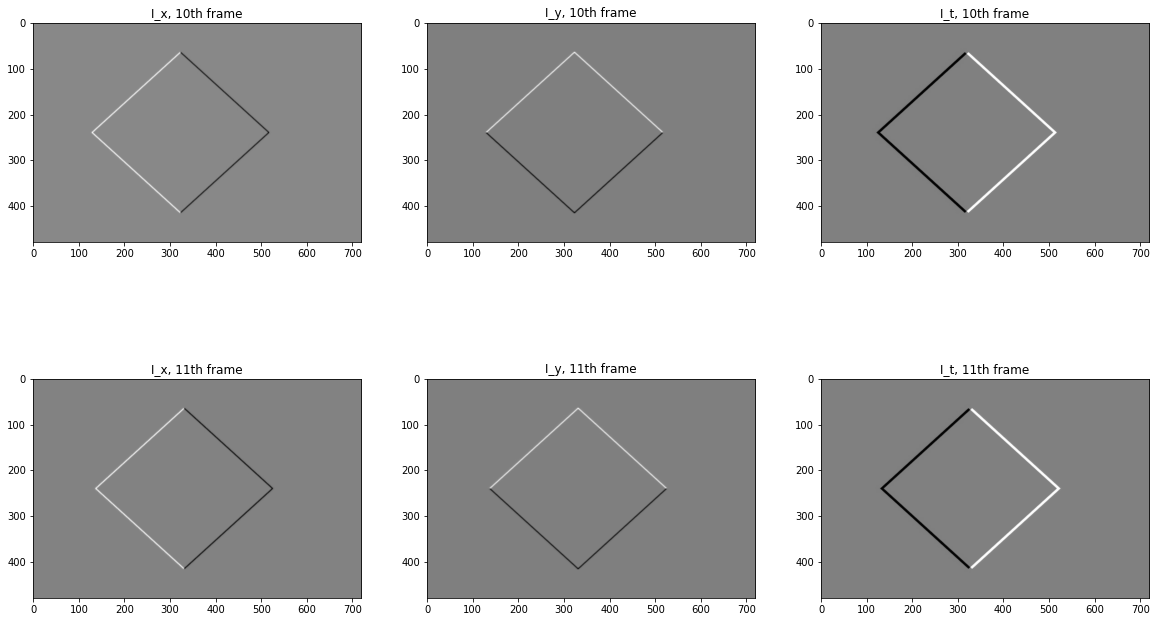

In [14]:
# Get image sequence and derivatives
image = get_image_sequence(str(path))

frame_start = 60
frame_end = 80
frame_considered = 70
relative_frame = frame_considered - frame_start

# Pass 20 frames of the image to get 19 derivatives derivatives
I_x, I_y, I_t = get_derivatives(image[frame_start:frame_end,:,:], print = True)

In [16]:
# Define scaler
scaler = MaxAbsScaler();
scaler.fit(I_x[relative_frame,:,:]);

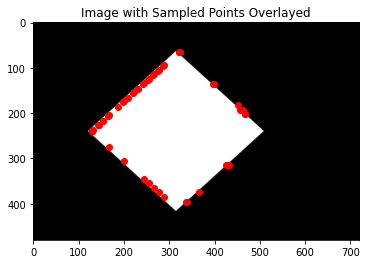

In [17]:
# Create a Gaussian window
window_size = 10
g = create_window(window_size)

#Define coordinates to sum likelihoods over
# coords, points = get_even_points(I_x[0,:,:].shape[1], I_x[0,:,:].shape[0], 100, 
#                                  window_size=window_size, frame_considered = frame_considered, 
#                                  print = True)

coords, points = get_points(relative_frame, I_x[0,:,:].shape[1], 
                           I_x[0,:,:].shape[0], I_x, I_y, I_t, num_points=20, 
                           printed = True)


# Define velocities
vx = [-0.2,0.2]
vy = [-.2,.2]

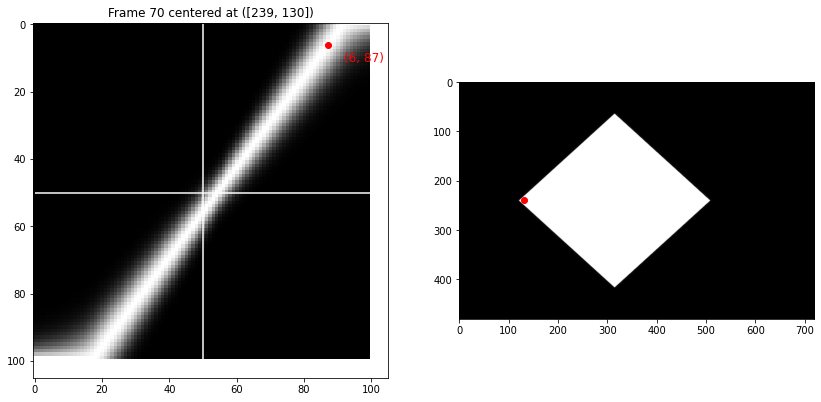

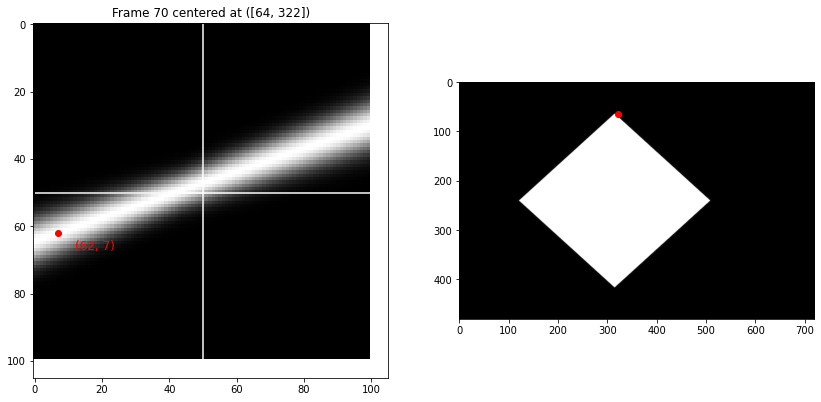

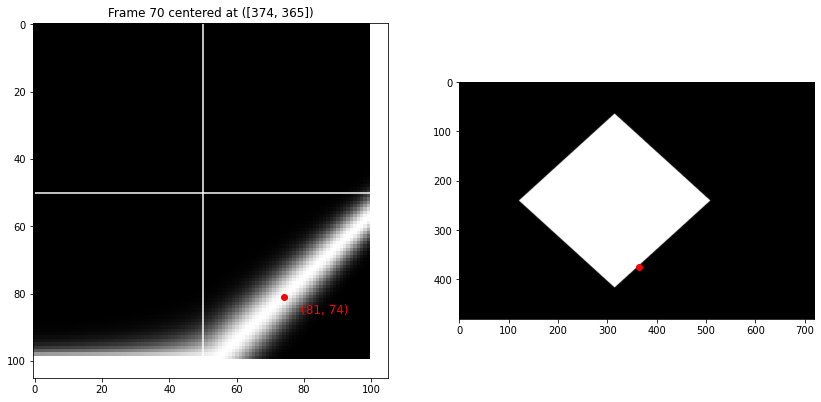

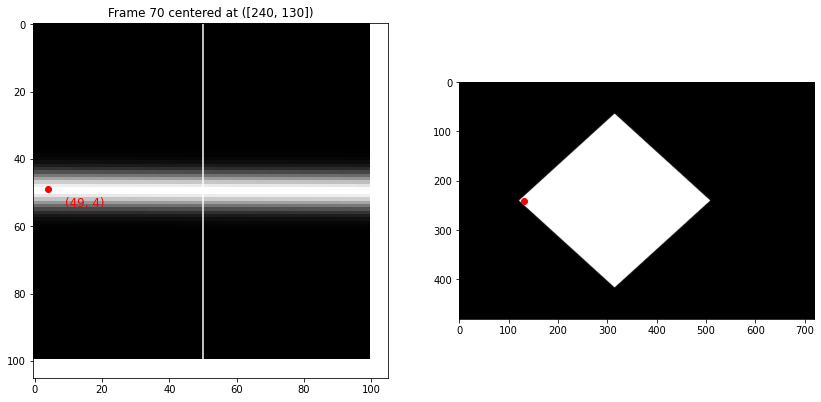

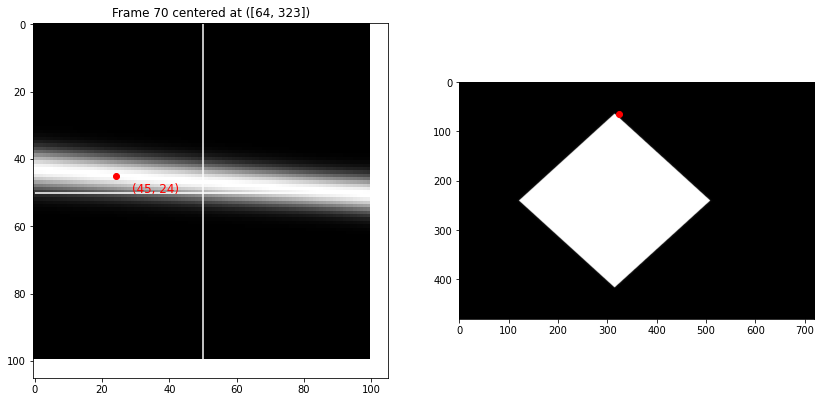

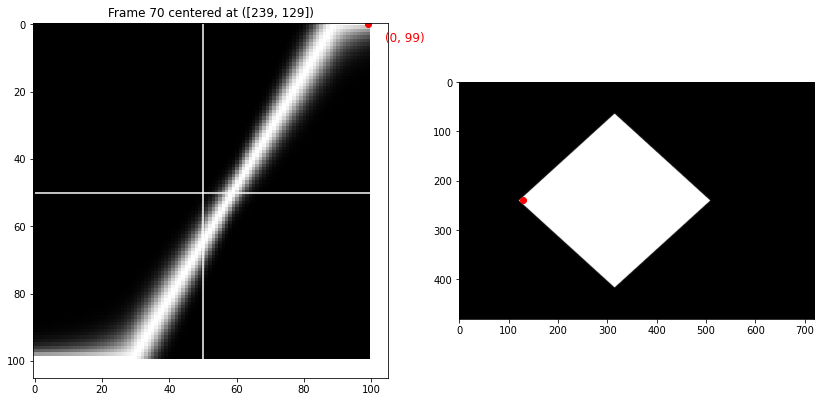

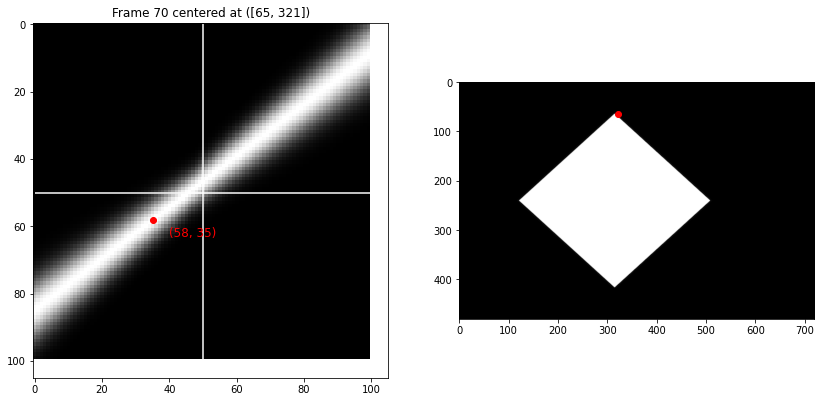

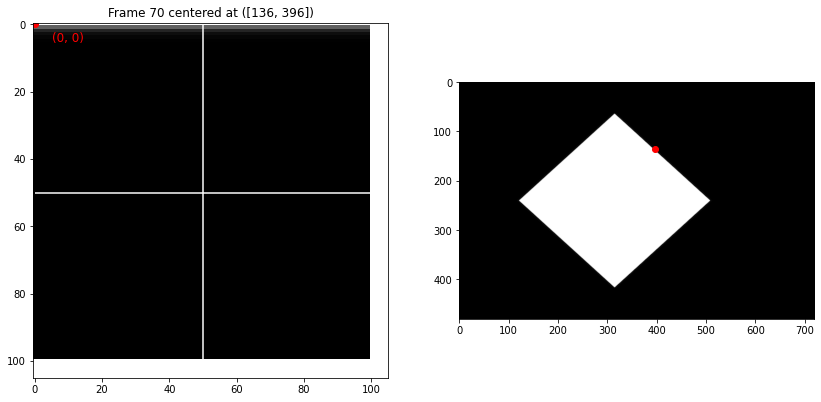

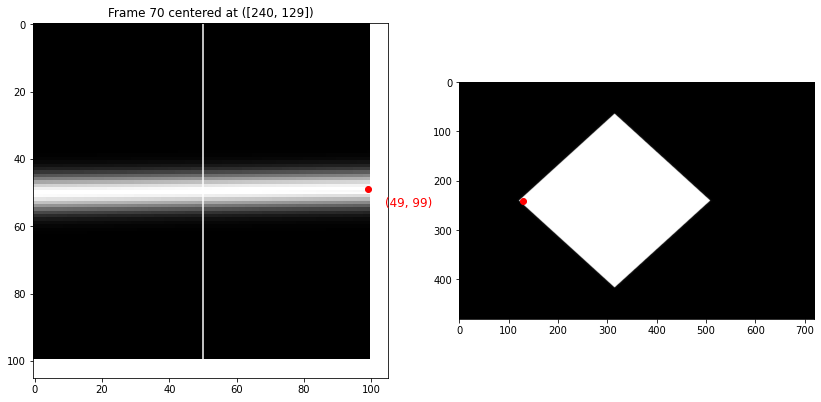

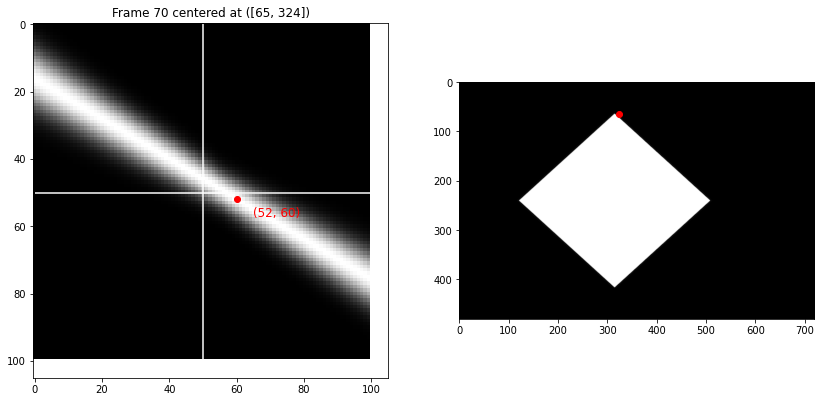

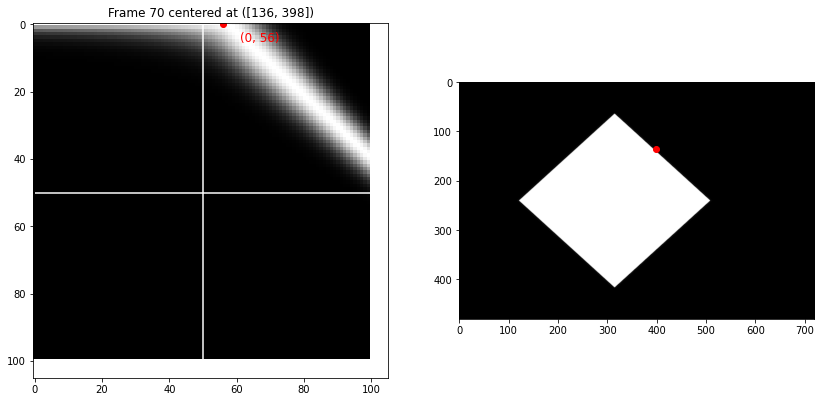

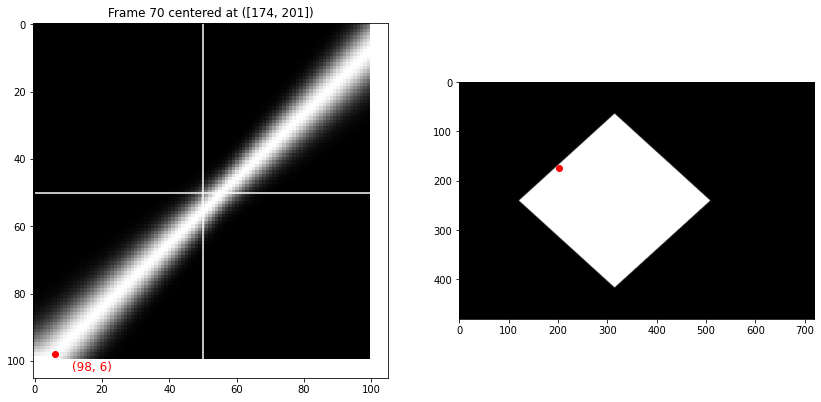

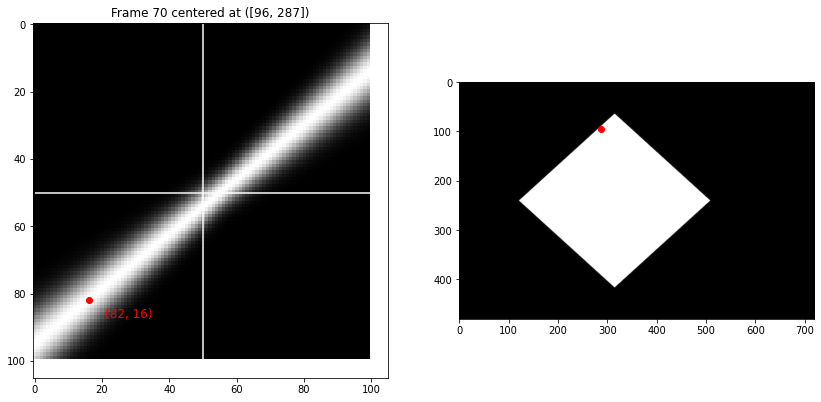

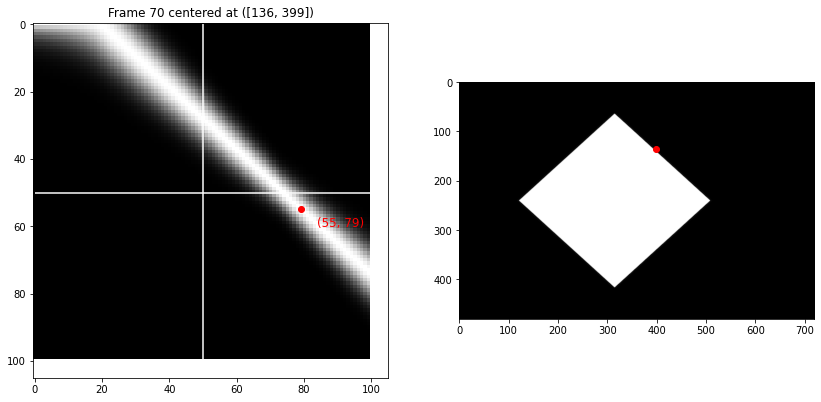

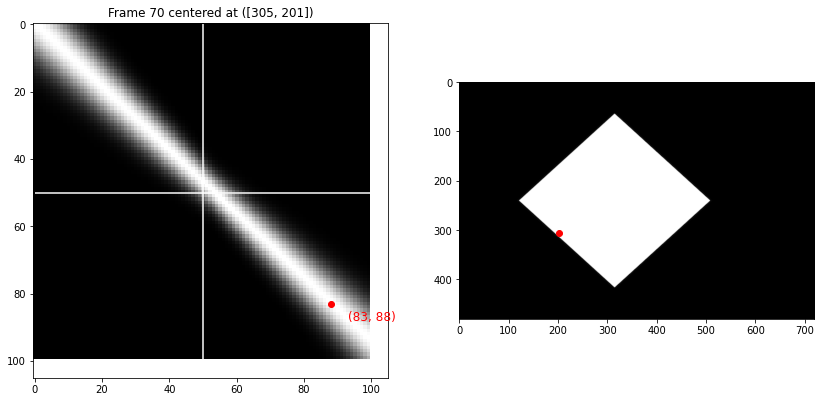

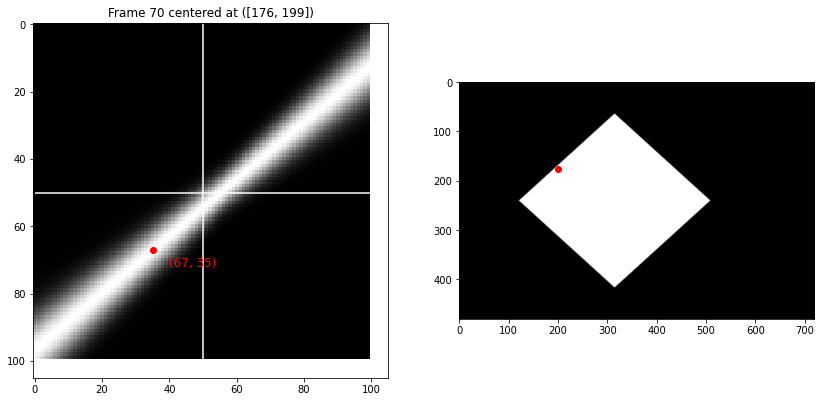

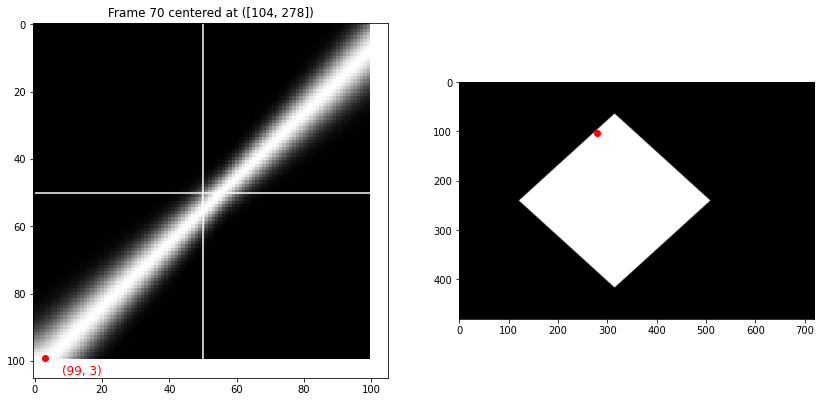

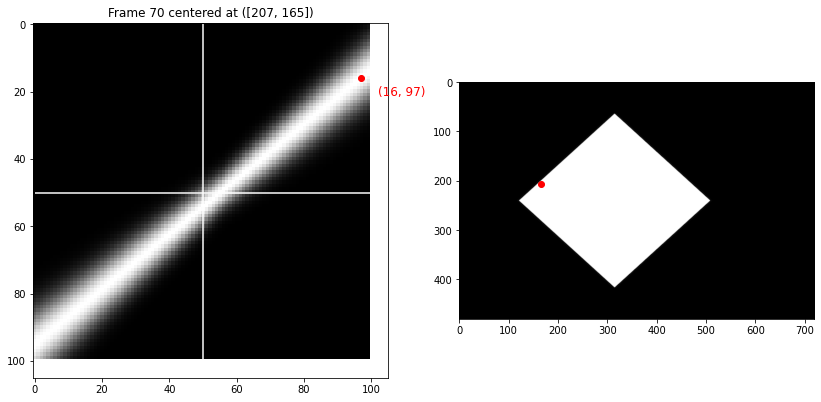

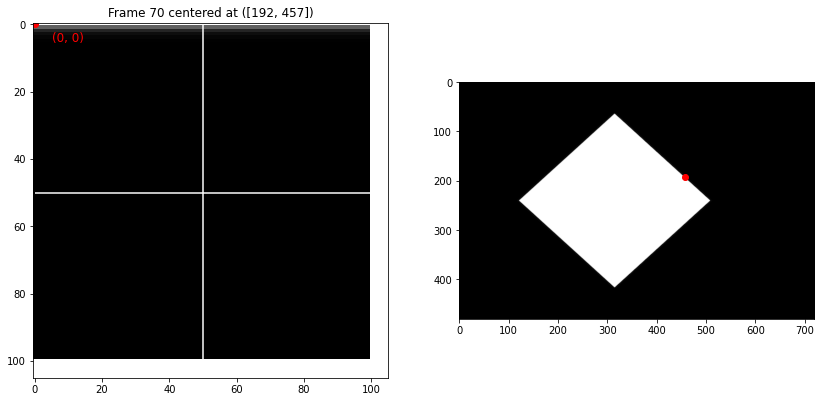

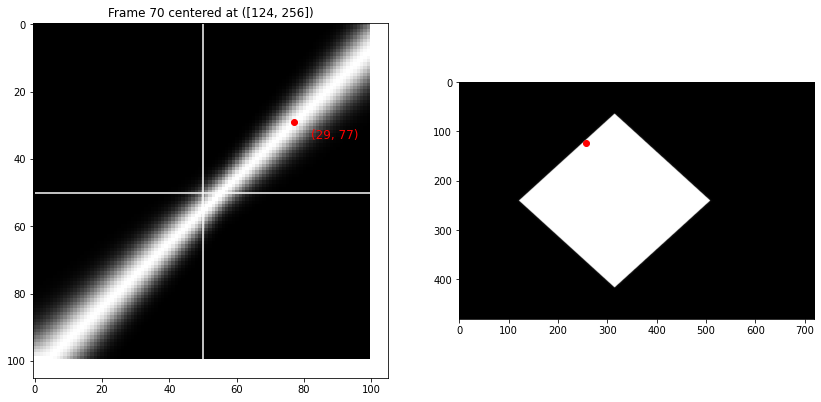

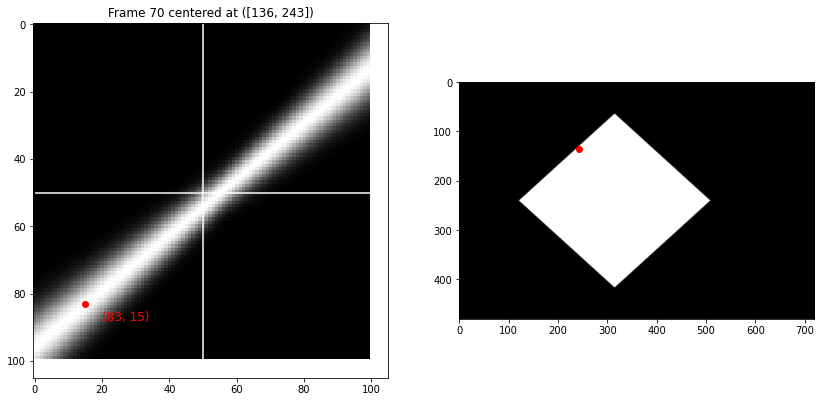

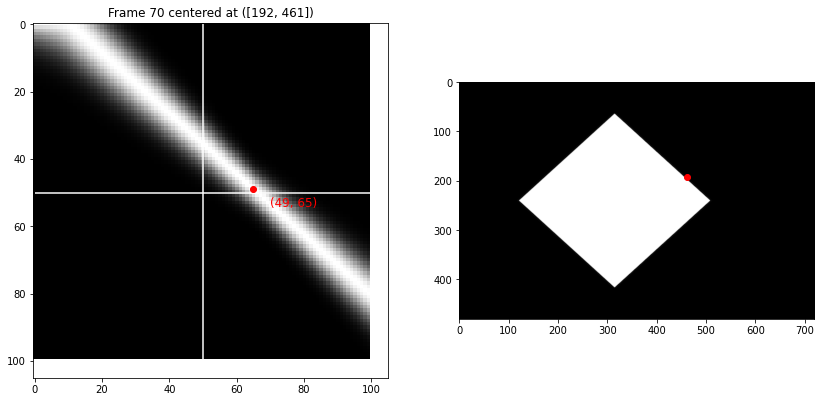

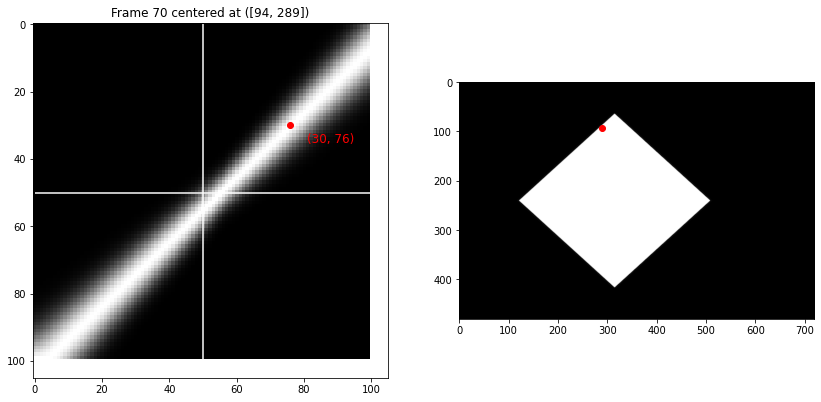

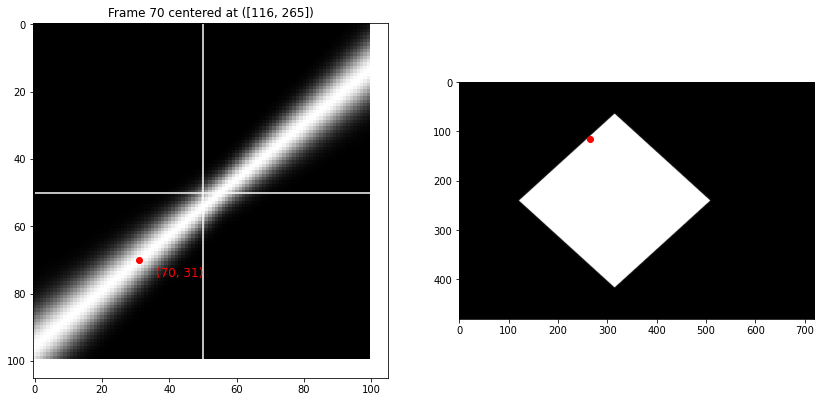

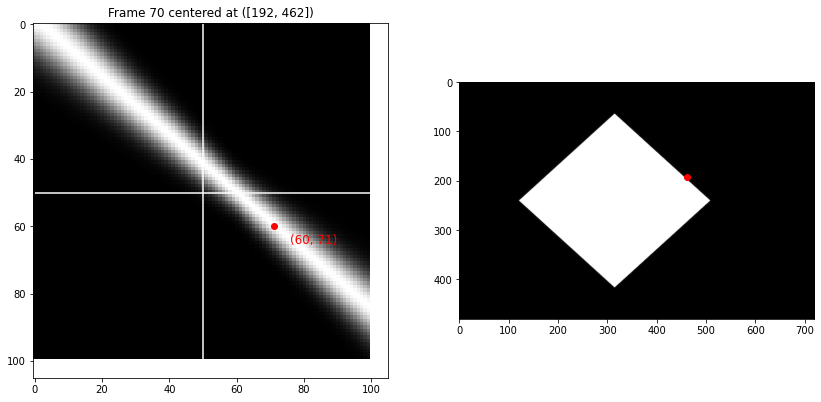

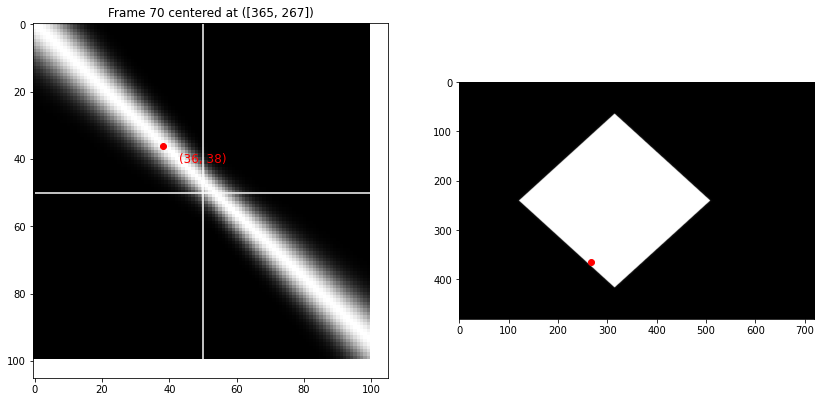

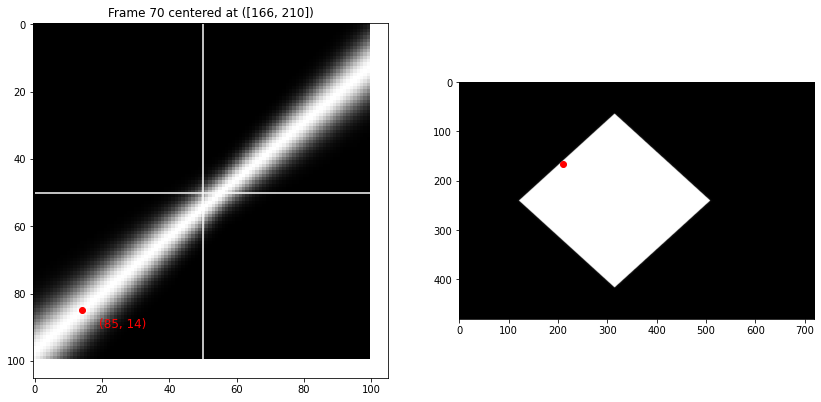

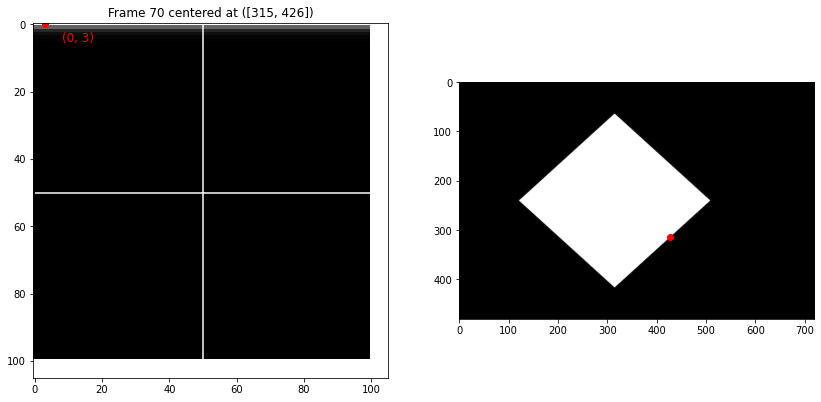

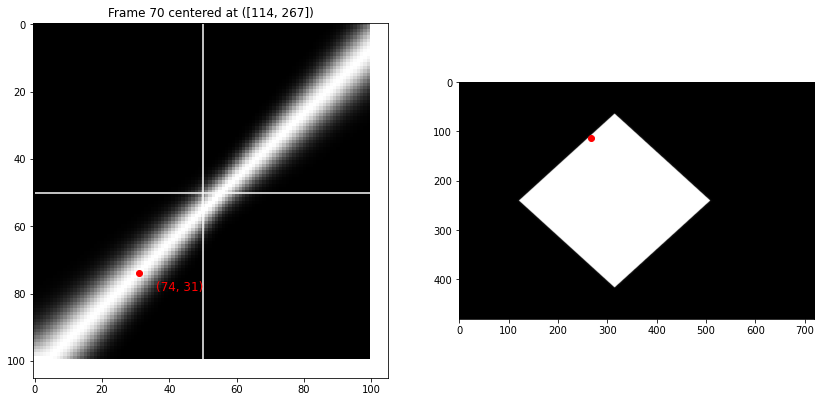

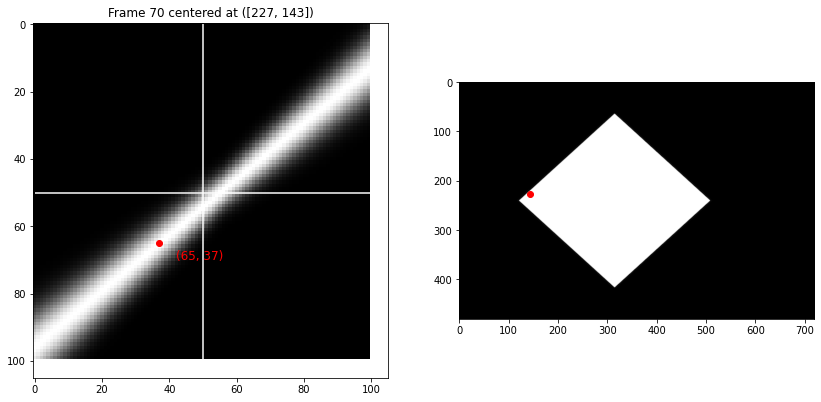

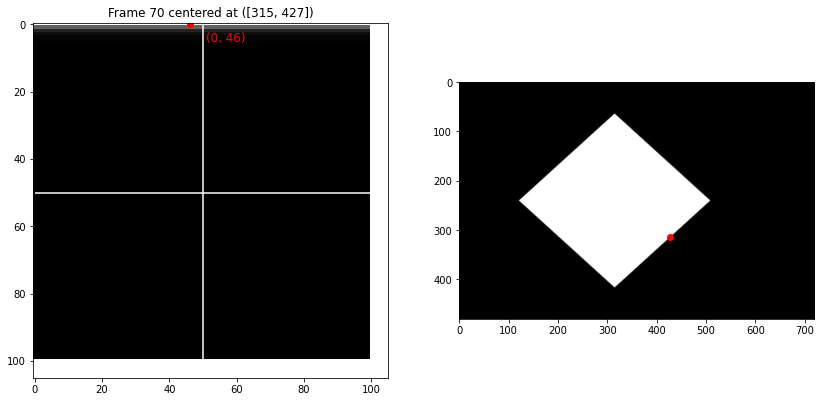

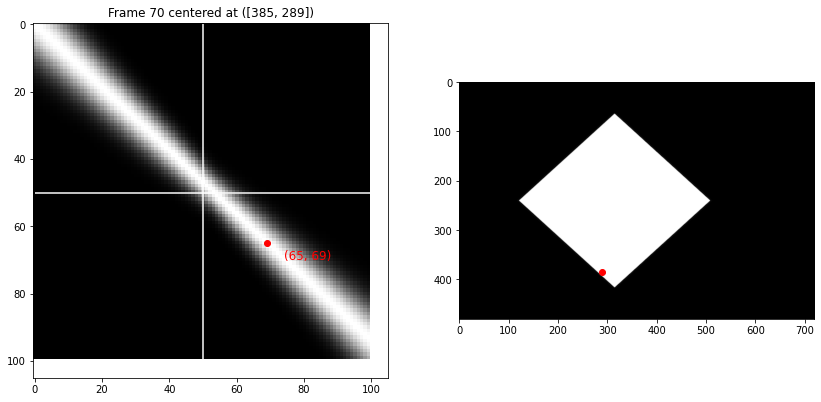

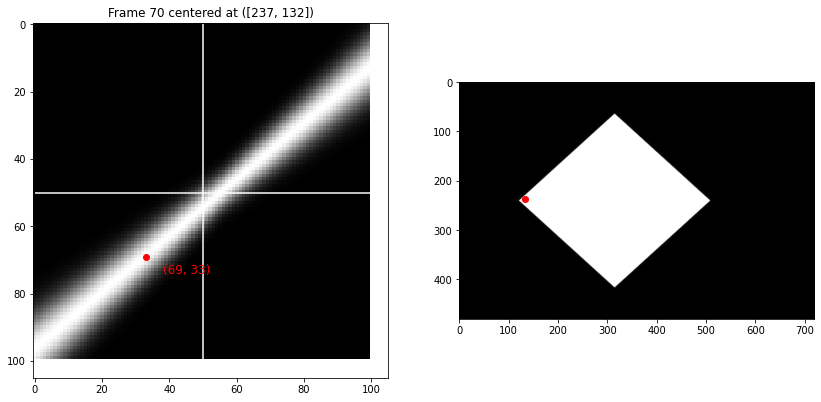

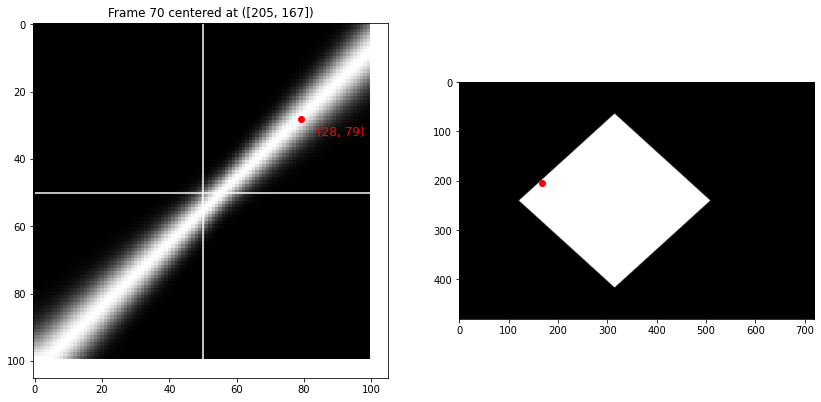

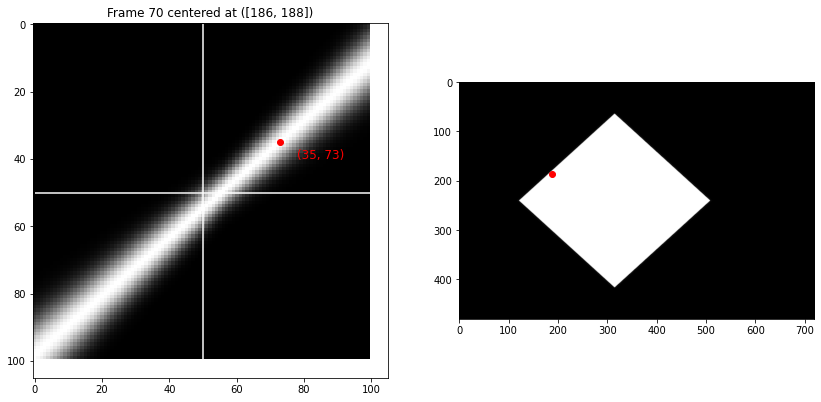

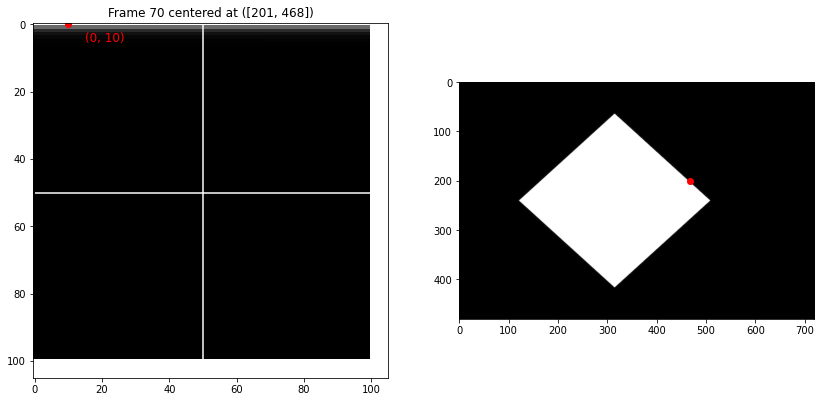

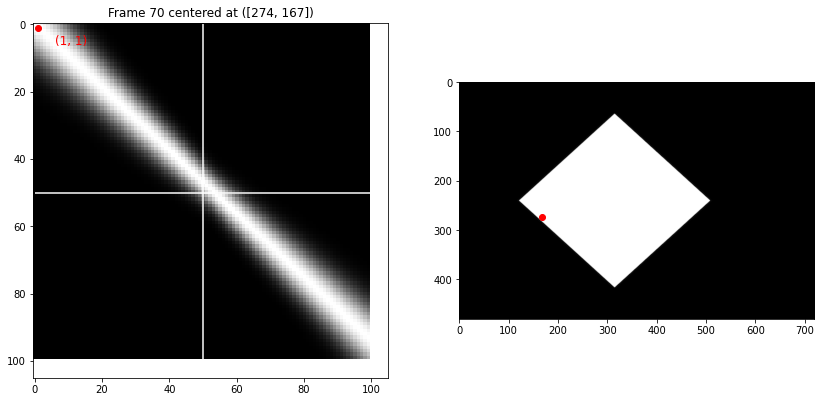

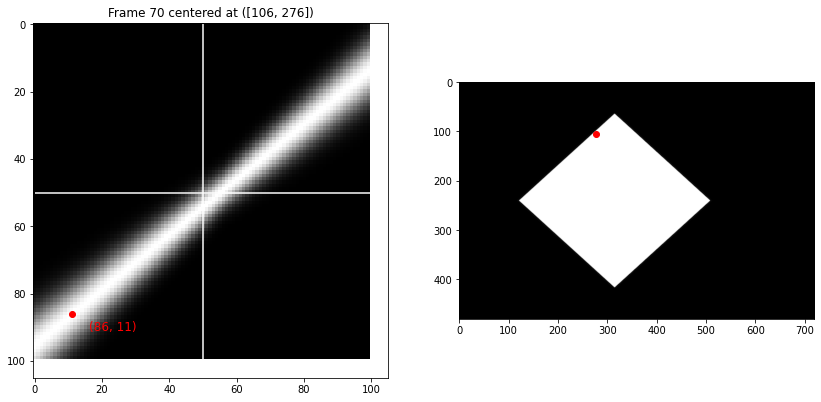

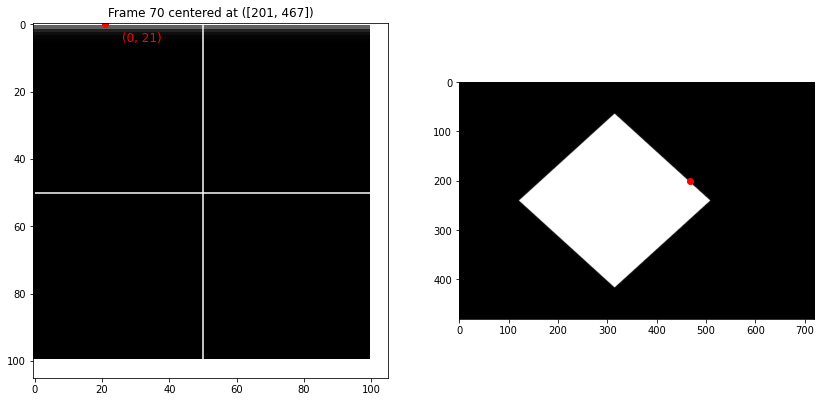

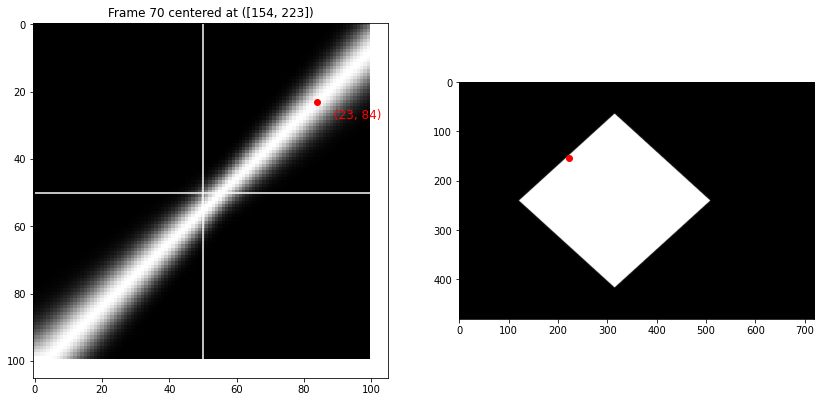

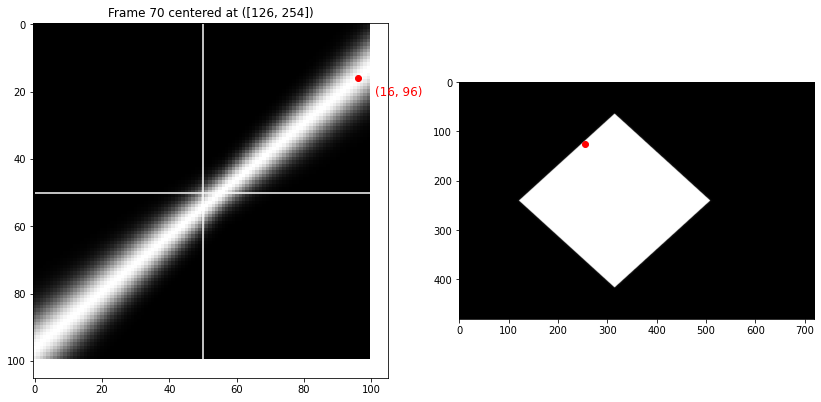

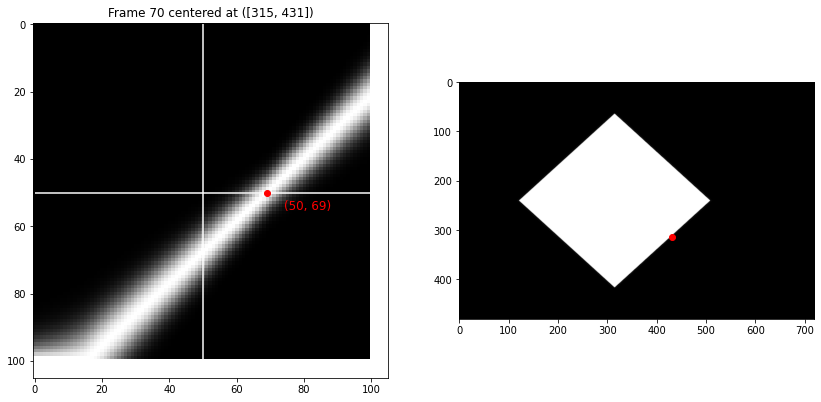

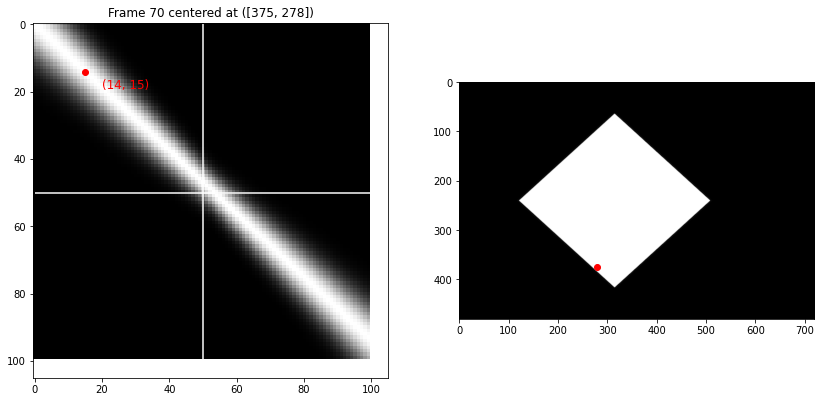

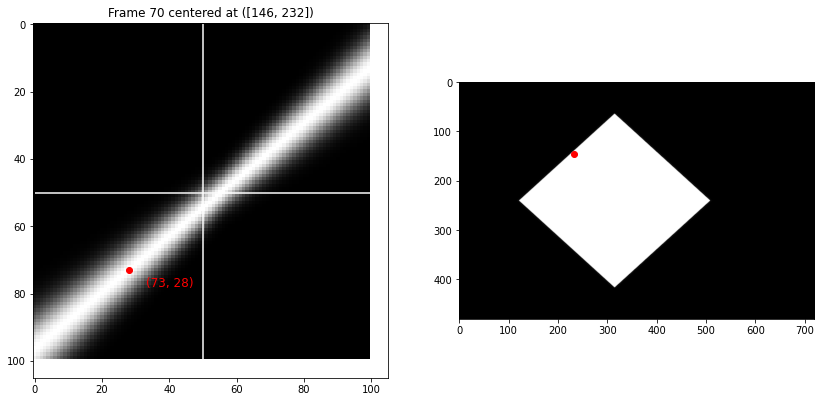

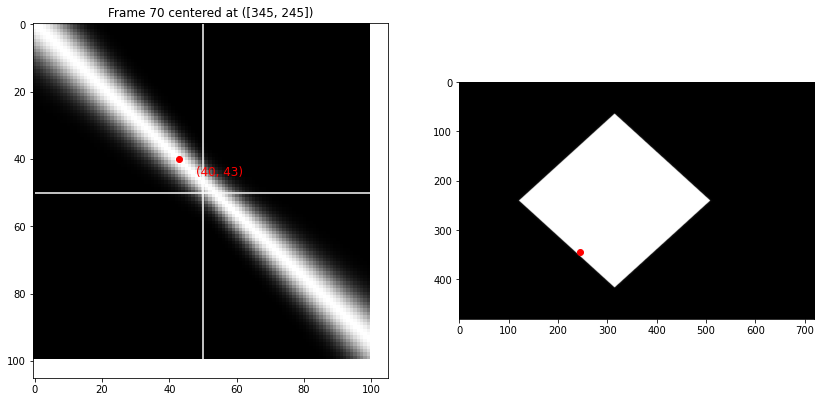

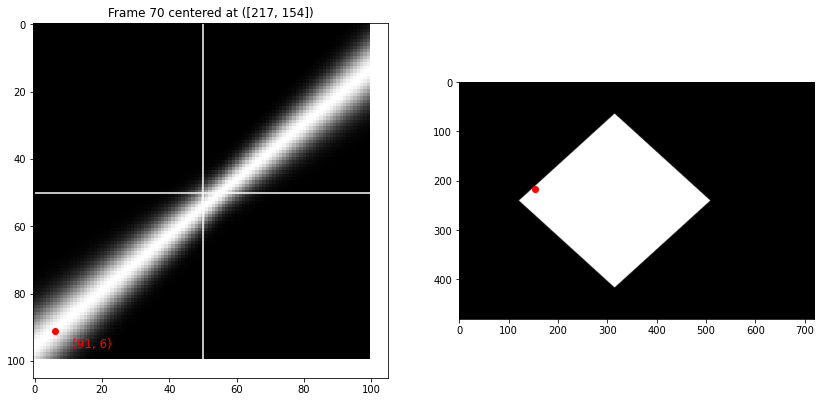

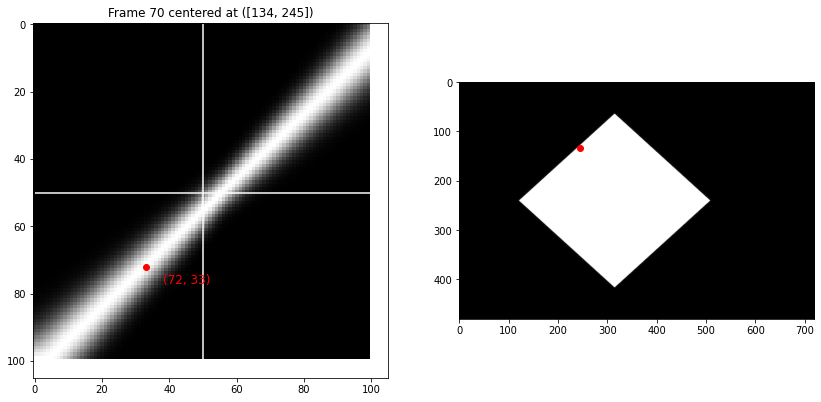

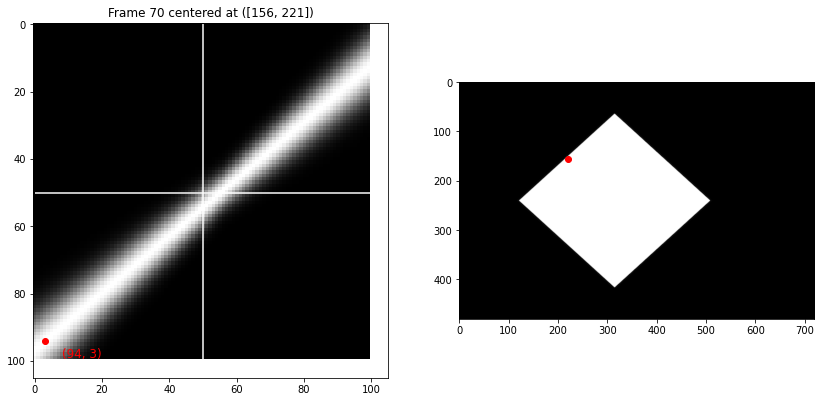

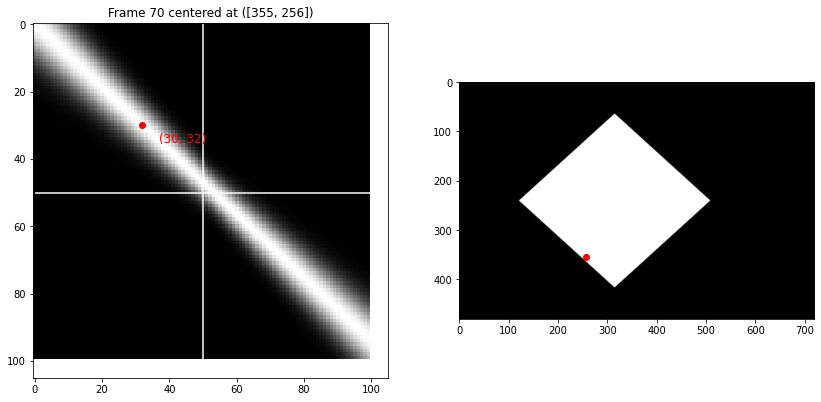

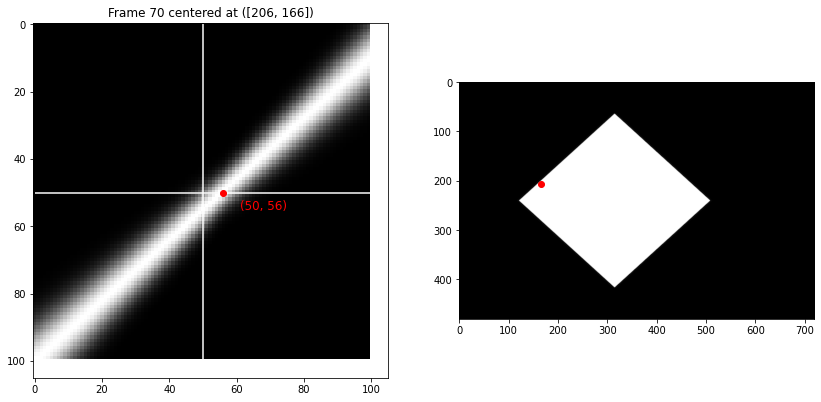

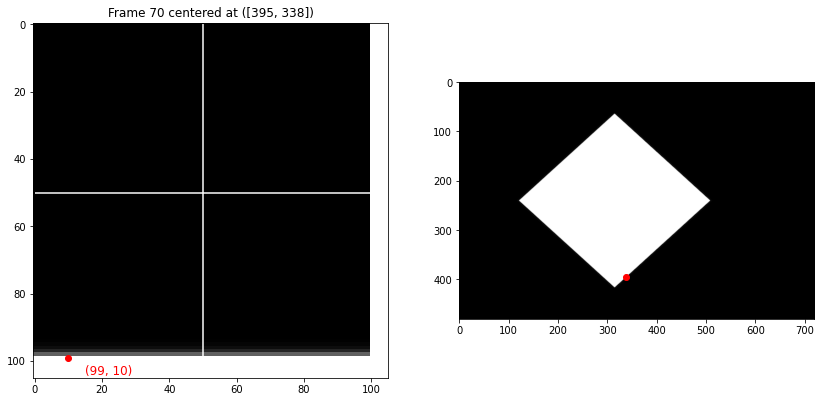

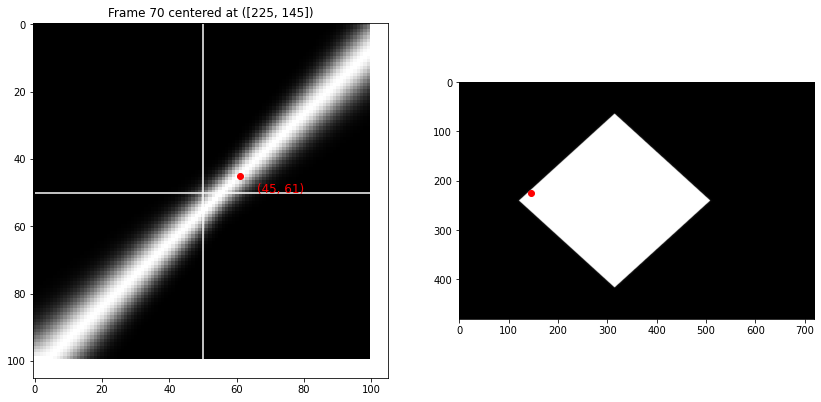

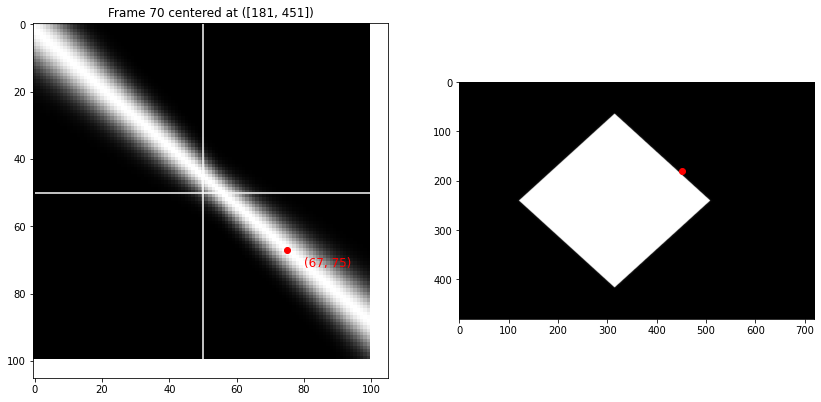

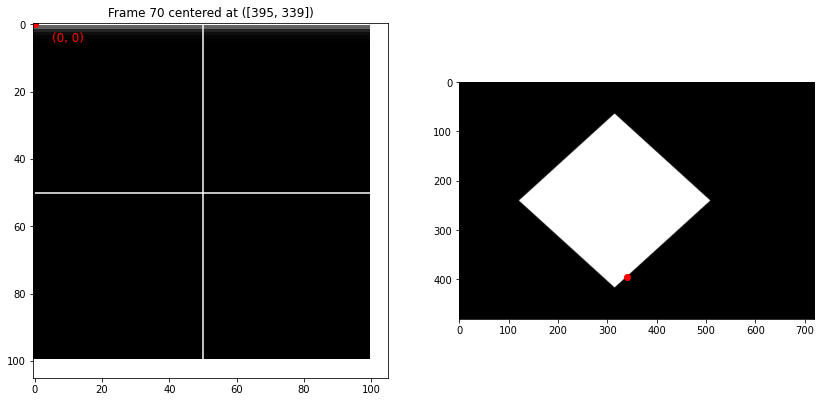

In [18]:
  sum, likelihoods = get_v_sum(coords, relative_frame, frame_considered, image, I_x, I_y, I_t, g, vx, vy, 
                scaler, variance = 0.01, print_points=False, print_likelihoods = True, scale = False)

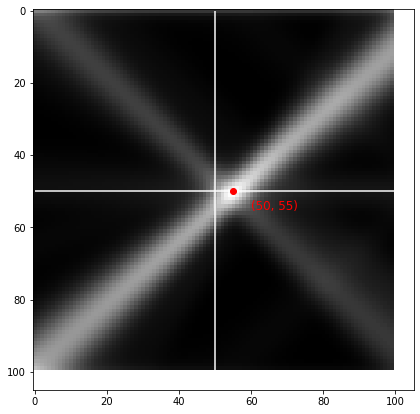

In [19]:
#Displaying the sum of the likelihoods
plot_likelihood(sum)

In [20]:
def imshow(ax, p):
    """Show the probabilities as a function of x and y velocities."""
    ax.imshow(p.T, origin='lower', interpolation='nearest', cmap='gray')
    xmid = (p.shape[1] - 1) / 2
    ymid = (p.shape[0] - 1) / 2
    ax.vlines(ymid, 0, p.shape[1], color='gray')
    ax.hlines(xmid, 0, p.shape[0], color='gray')
    ax.set_xticks([])
    ax.set_yticks([])

In [21]:
scaler1 = MinMaxScaler(feature_range=(0, 255))
def scaled(arr):
  arr_vec = arr.reshape(-1, 1)
  return scaler1.fit_transform(arr_vec).reshape(arr.shape[0], arr.shape[1])

def feedback(prior, sum, fig, axes):
  v_x, v_y = None, None
  posterior = np.multiply(scaled(prior), scaled(sum))
  MAP = np.unravel_index(np.argmax(posterior), posterior.shape)
  fig.set_size_inches(12, 3)

  imshow(axes[0], scaled(prior))
  axes[0].set_title('Prior')
  
  imshow(axes[1], scaled(sum))
  axes[1].set_title('Sum over likelihoods')

  title = 'Posterior, v = [' + str(MAP[0]) + ',' + str(MAP[1]) + ']'

  imshow(axes[2], posterior)
  axes[2].set_title(title)
  axes[2].autoscale(enable=False)
  axes[2].plot(MAP[0], MAP[1], 'ro')
  return fig, posterior

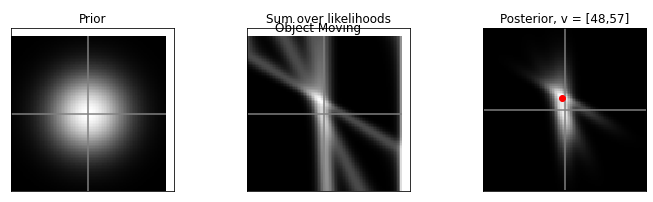

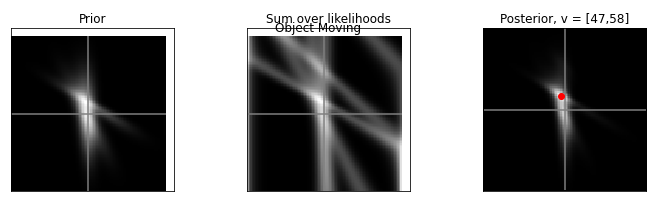

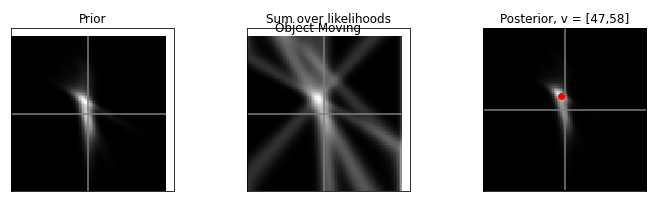

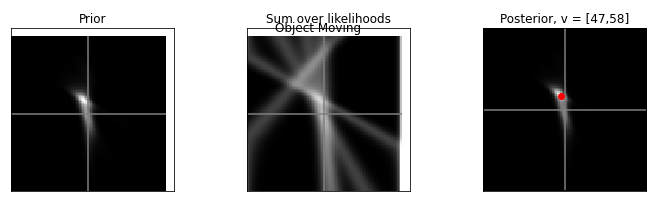

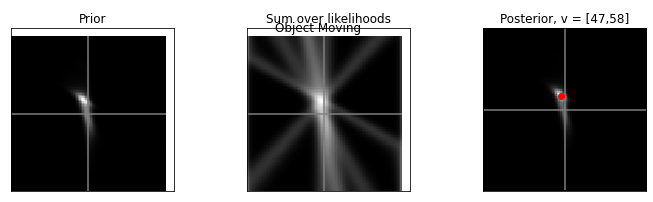

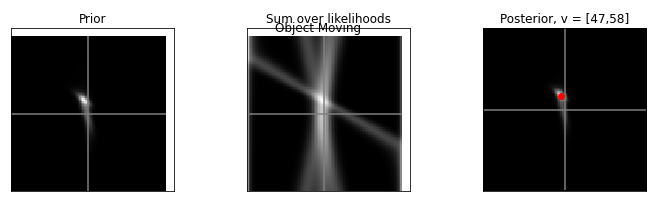

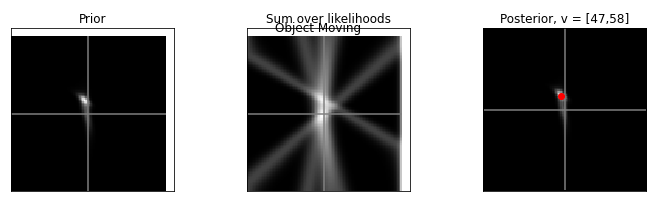

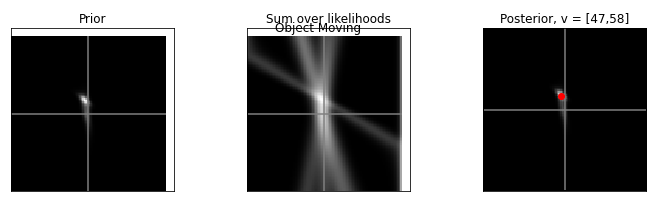

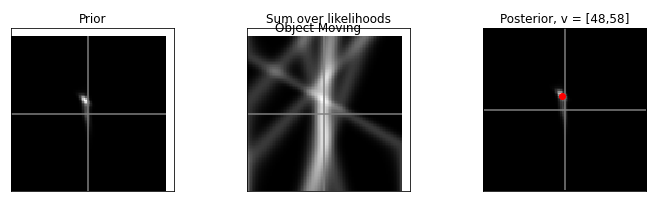

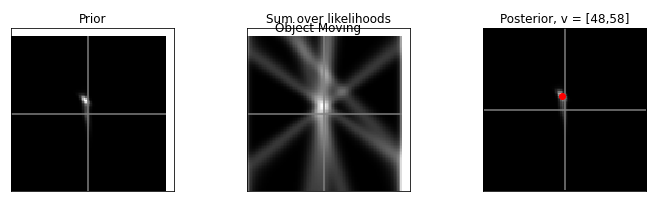

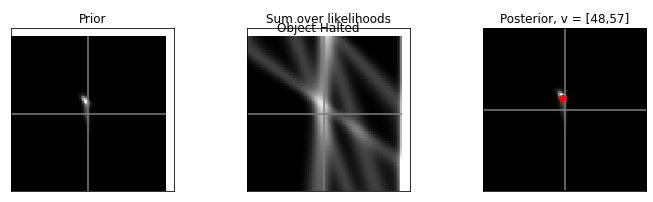

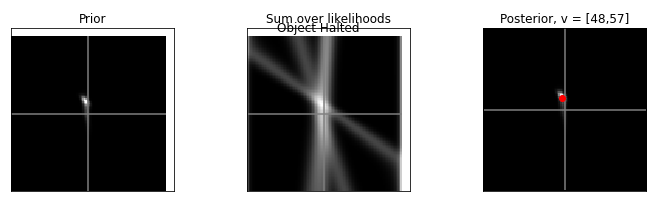

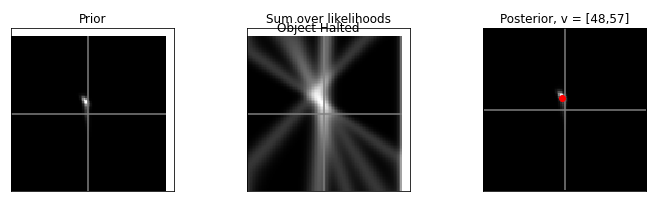

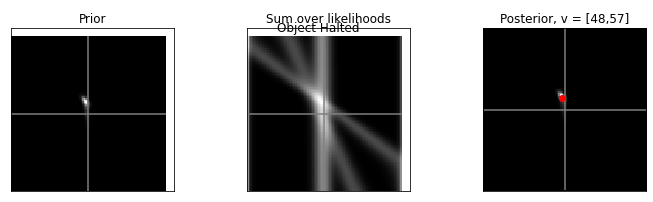

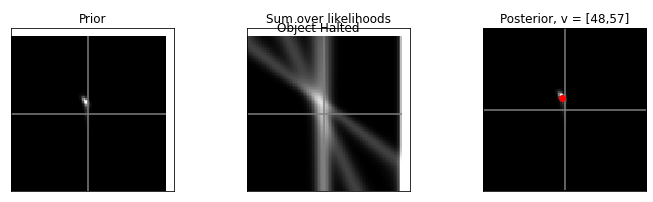

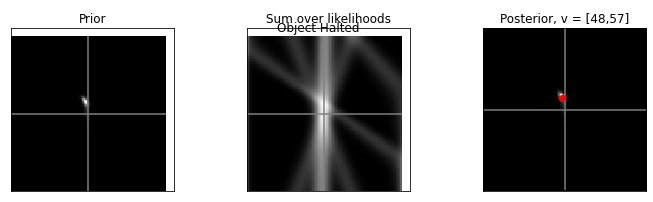

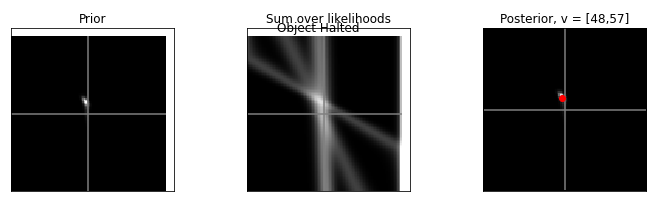

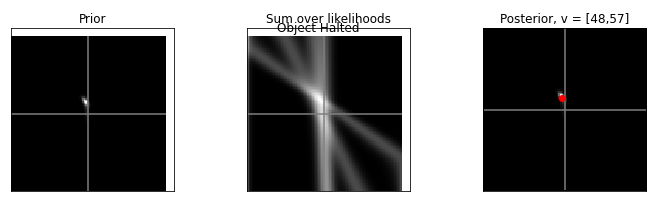

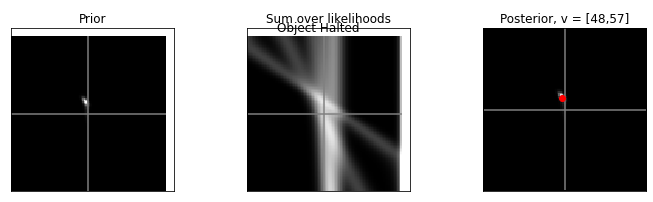

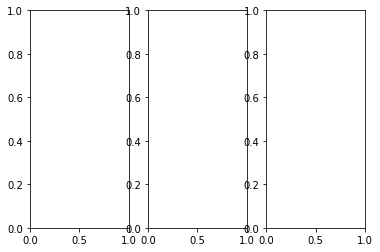

In [18]:
prior = create_window(100)
fig, axes = plt.subplots(1, 3)
frame_start = 50
frame_end = 70
coords, points = get_even_points(I_x[0,:,:].shape[1], I_x[0,:,:].shape[0], 50, 
                                 window_size=window_size, frame_considered = frame_considered, 
                                 print = False)

for relative_frame in range(0, frame_end-frame_start-1):
  if relative_frame < 10:
    fig.suptitle("\nObject Moving\n")
  else:
    fig.suptitle("\nObject Halted\n")
  frame_considered = frame_start + relative_frame
  indices = np.random.choice(len(coords),4)
  c = [coords[ix] for ix in indices]
  coords, points = get_points(relative_frame, I_x[0,:,:].shape[1], 
                           I_x[0,:,:].shape[0], I_x, I_y, I_t, num_points=2, 
                           printed = False)
  coords.extend(c)
  sum, likelihoods = get_v_sum(coords, relative_frame, frame_considered, image, I_x, I_y, I_t, g, vx, vy, 
                scaler, variance = 0.1, print_points=False, print_likelihoods = False, scale = False)
  
  fig, prior = feedback(prior, sum, fig, axes)
  fig, axes = plt.subplots(1, 3)

# Synthetic Data Approximation

Due to the limitations of manually extracting likelihoods from video data, synthetic data is produced to test the viability of the feedback through time mechanism

In [20]:
def imshow(ax, p):
    """Show the probabilities as a function of x and y velocities."""
    ax.imshow(p.T, origin='lower', interpolation='nearest', cmap='gray')
    xmid = (p.shape[1] - 1) / 2
    ymid = (p.shape[0] - 1) / 2
    ax.vlines(ymid, 0, p.shape[1], color='gray')
    ax.hlines(xmid, 0, p.shape[0], color='gray')
    ax.set_xticks([])
    ax.set_yticks([])

def uniform(x, low, high):
    """Compute the log probability for a uniform random variable between (low, high)."""
    return scipy.stats.uniform.logpdf(x, low, high - low)

def norm(x, mu, sigma):
    """Compute the log probability for a Gaussian random variable with parameters μ and σ."""
    return scipy.stats.norm.logpdf(x, mu, sigma)

In [21]:
#These functions are taken from http://jhamrick.github.io/quals/probabilistic%20models%20of%20perception/2015/11/09/Weiss2002-ipynb.html

def prior1(vx, vy):
    """Zero-mean Gaussian prior with σ=25"""
    return norm(vx, 0, 25) + norm(vy, 0, 25)

def prior2(vx, vy):
    """Velocity Average (VA) Gaussian prior with σ=5"""
    return norm(vx, 17.88461538, 5) + norm(vy, -14.42307692, 5)

def prior3(vx, vy):
    """Uniform prior between -50 and 50"""
    return uniform(vx, -50, 100) + uniform(vy, -50, 100)

In [22]:
def model(prior, sigma, fig, axes, change_v=False, gaussian_likelihood = False):

    if gaussian_likelihood:  # Set gaussian_likelihood to true when the "stimulus" isn't moving
      lh1 = prior1(vx, vy)
      lh2 = prior1(vx, vy)
    else:
      lh1 = uniform(vx, -50, 100) + norm(vy - vx + 30, 0, sigma)
      lh2 = uniform(vx, -50, 100) + norm(vy+45 - 1.5*vx +45, 0, sigma)
      if change_v:
        lh1 = uniform(vx, -50, 100) + norm(vy - vx, 0, sigma)
        lh2 = uniform(vx, -50, 100) + norm(-1.5* vy - vx, 0, sigma)

    posterior = lh1 + lh2 + prior
    MAP = np.unravel_index(np.argmax(posterior), posterior.shape)

    fig.set_size_inches(12, 3)

    imshow(axes[0], np.exp(prior))
    axes[0].set_title('Prior')
    
    imshow(axes[1], np.exp(lh1))
    axes[1].set_title('Likelihood 1')
    
    imshow(axes[2], np.exp(lh2))
    axes[2].set_title('Likelihood 2')
    
    # To track v_x and v_y
    v_x = vx[MAP[0]]
    v_y = vy[0][MAP[1]]
    v_x = v_x[0]

    title = 'Posterior, v = [' + str(v_x) + ',' + str(v_y) + ']'

    imshow(axes[3], np.exp(posterior))
    axes[3].set_title(title)
    axes[3].autoscale(enable=False)
    axes[3].plot(MAP[0], MAP[1], 'ro')
    return fig, posterior, v_x, v_y

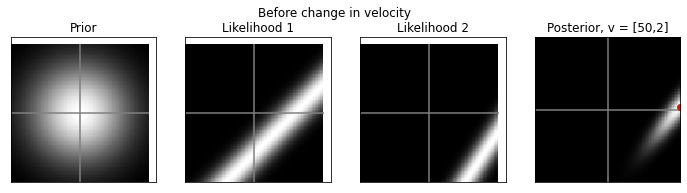

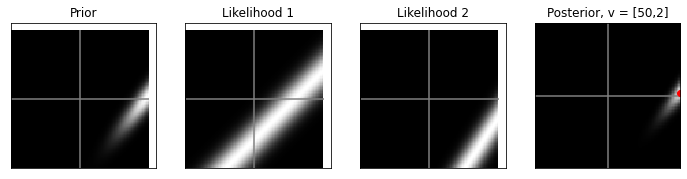

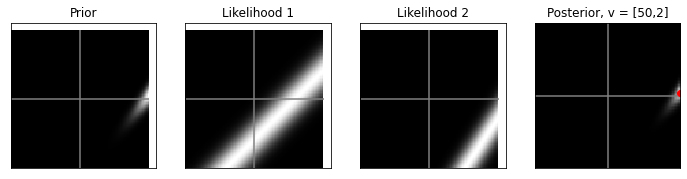

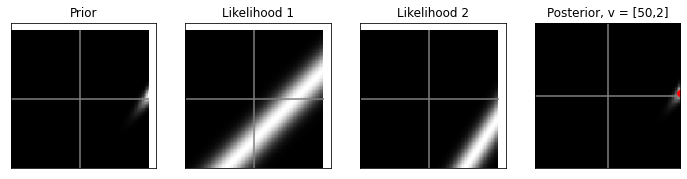

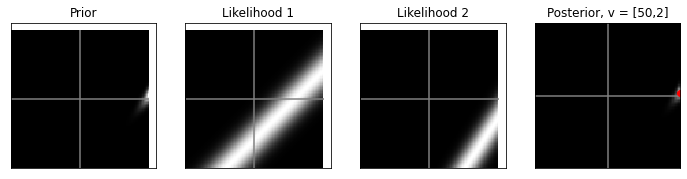

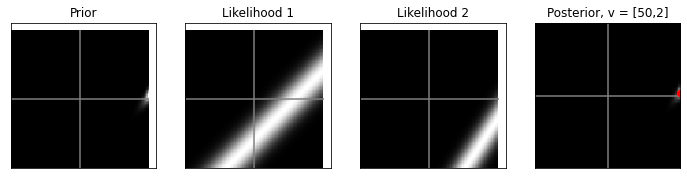

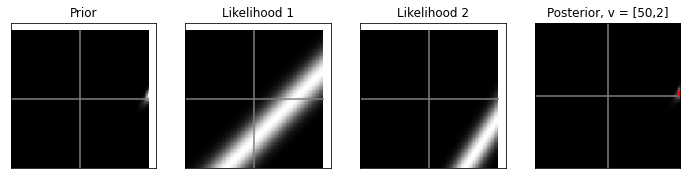

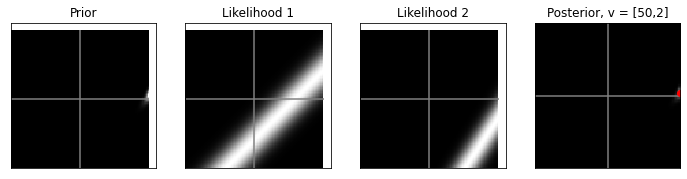

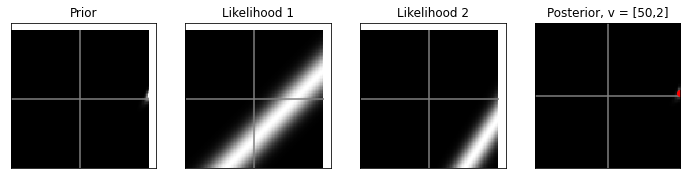

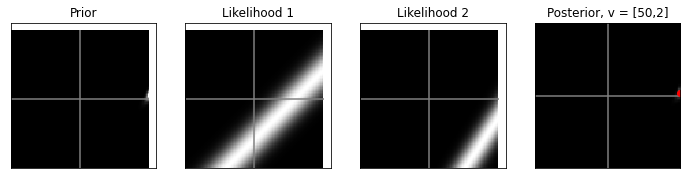

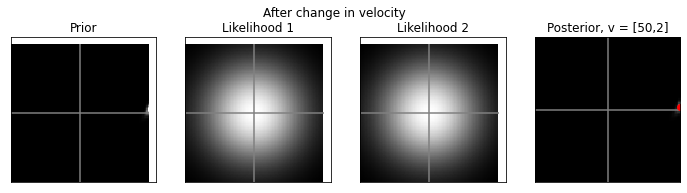

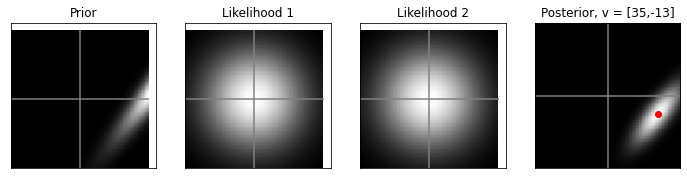

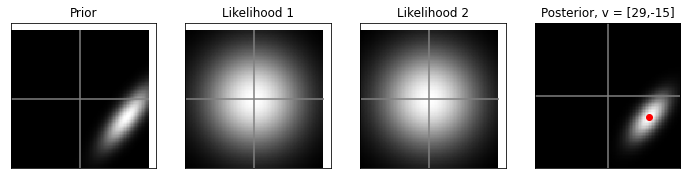

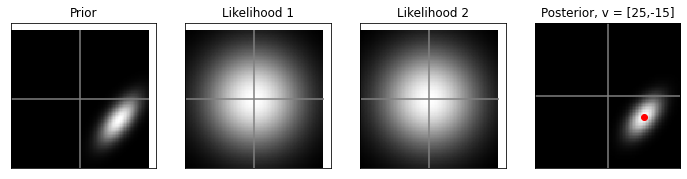

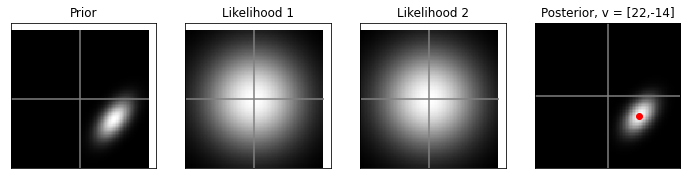

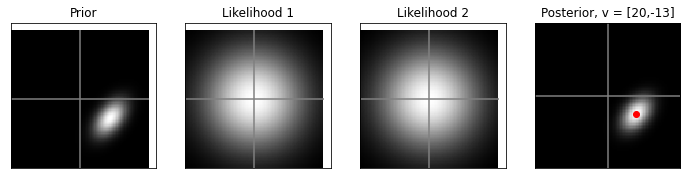

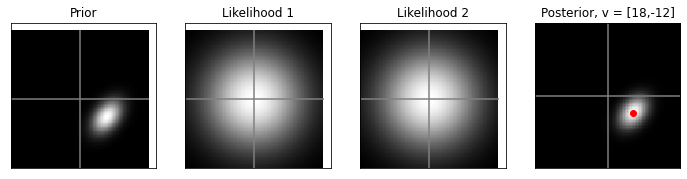

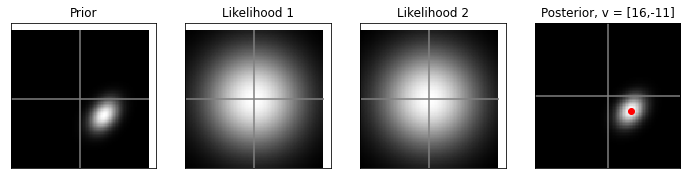

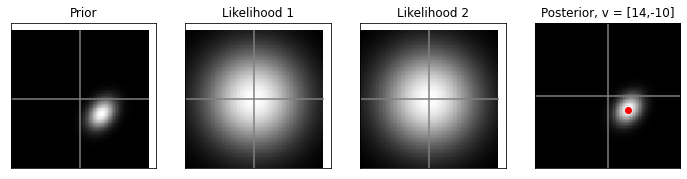

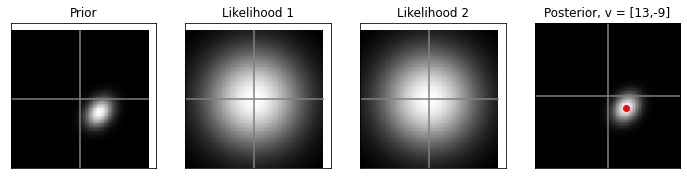

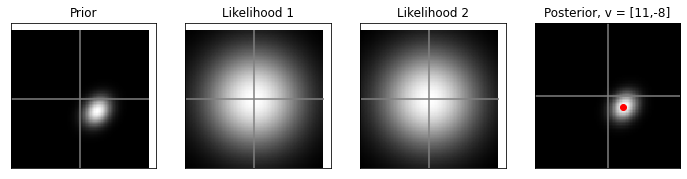

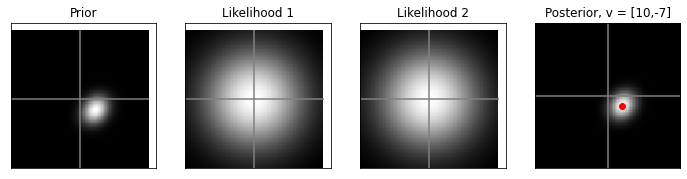

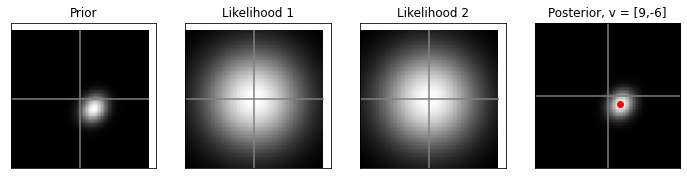

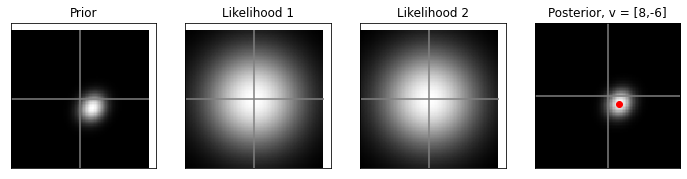

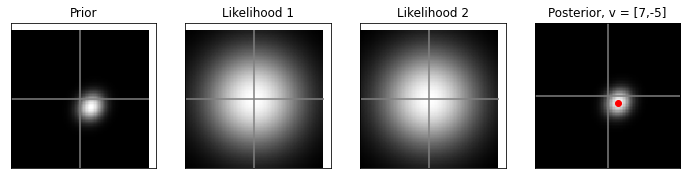

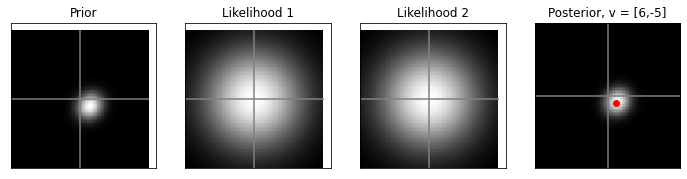

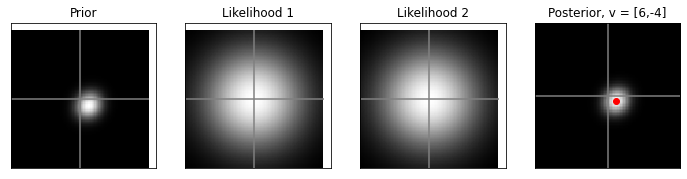

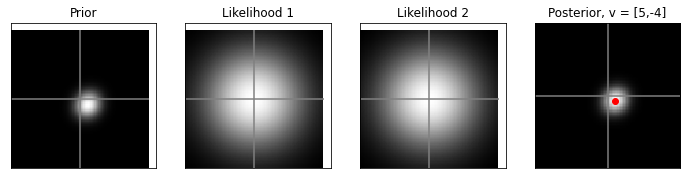

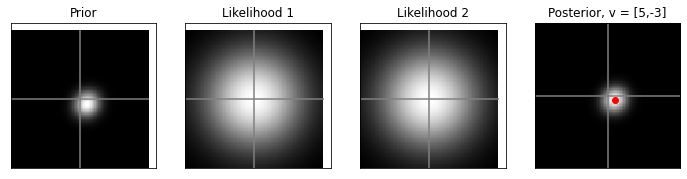

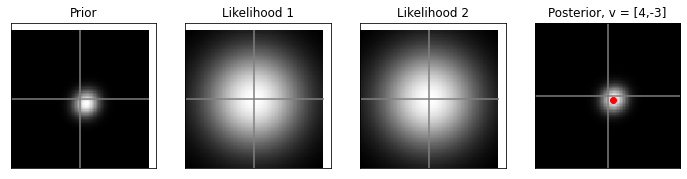

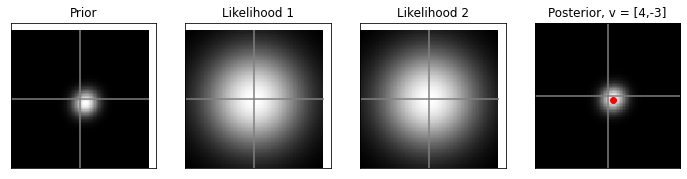

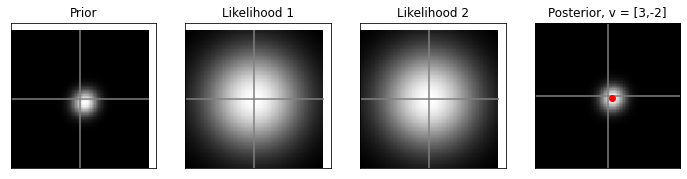

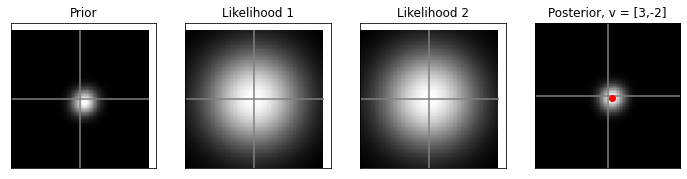

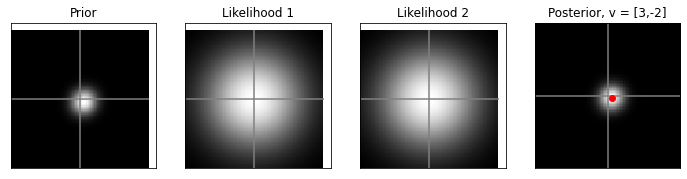

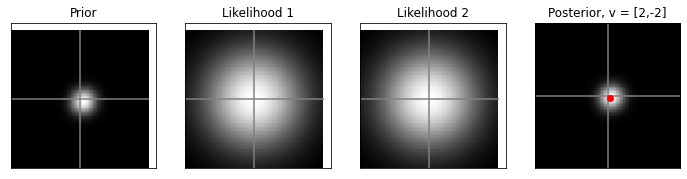

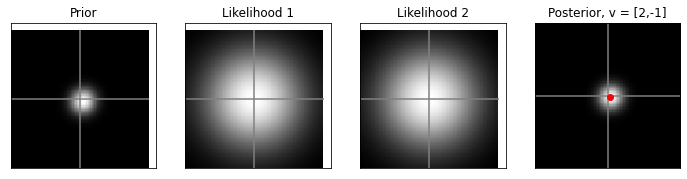

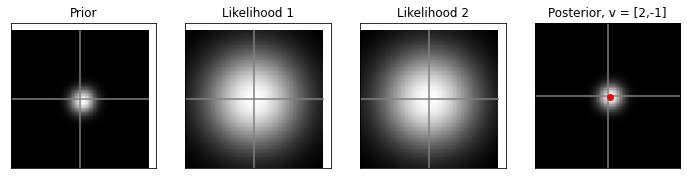

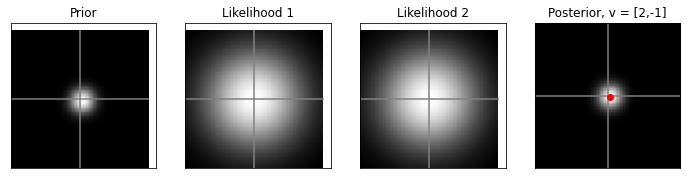

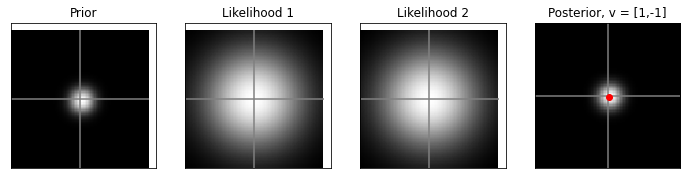

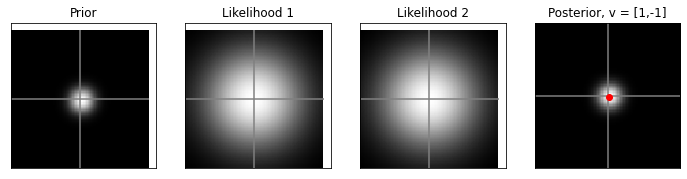

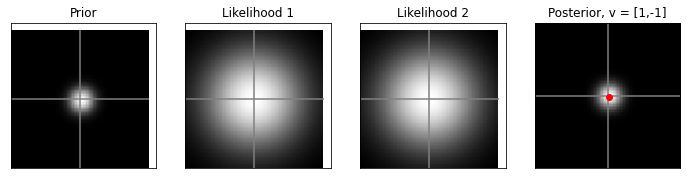

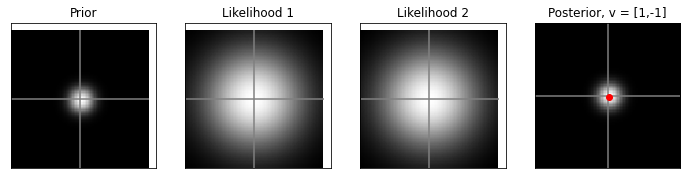

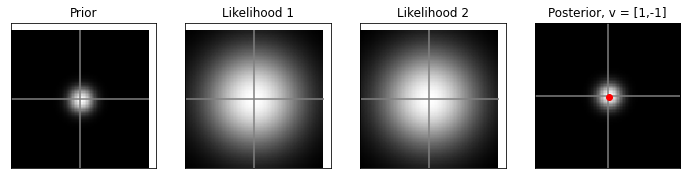

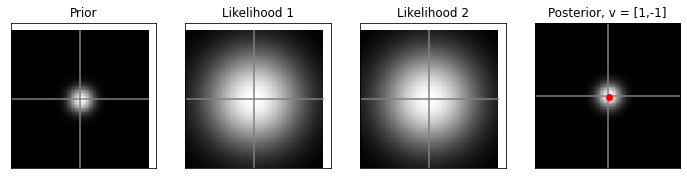

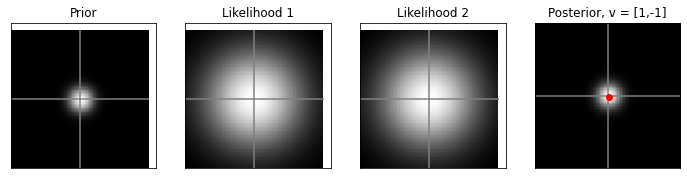

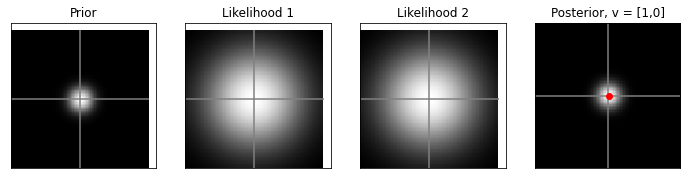

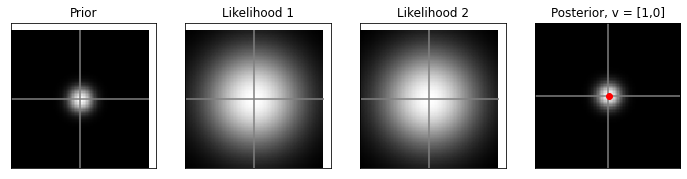

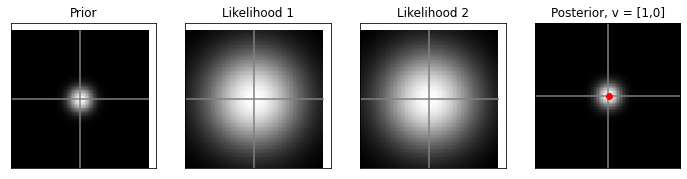

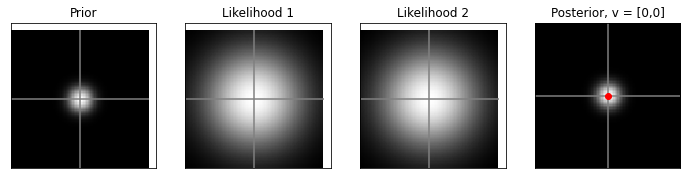

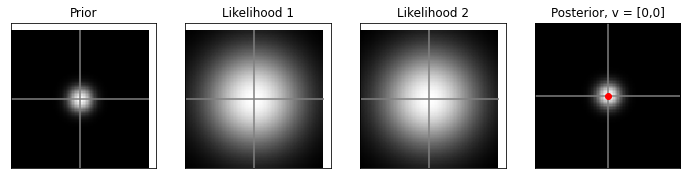

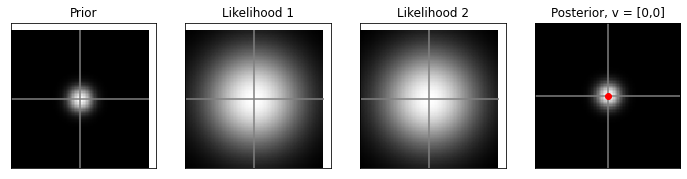

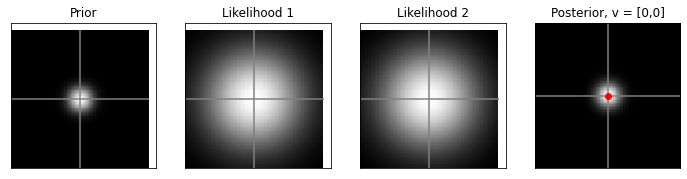

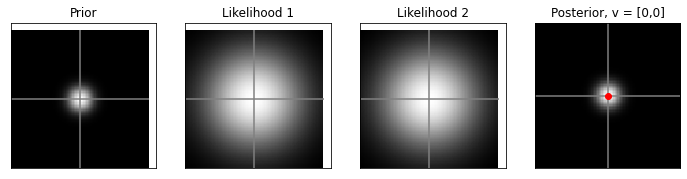

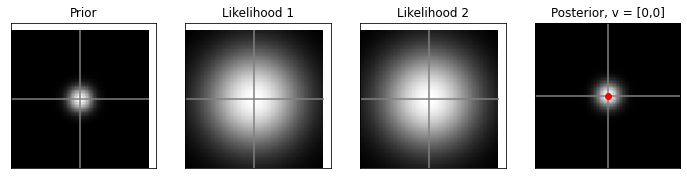

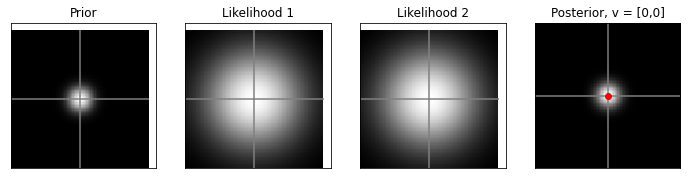

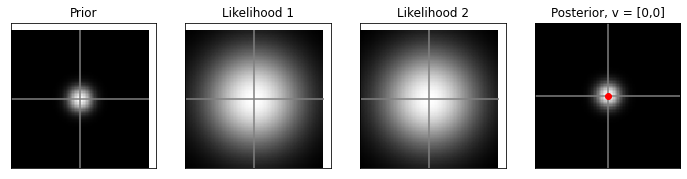

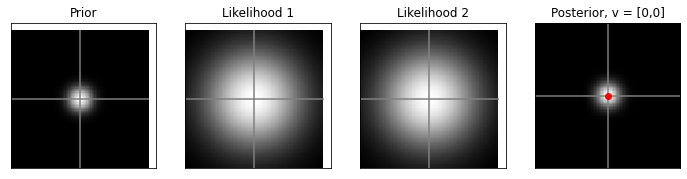

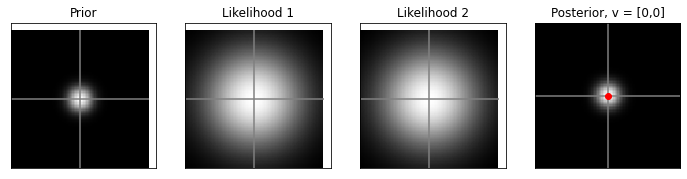

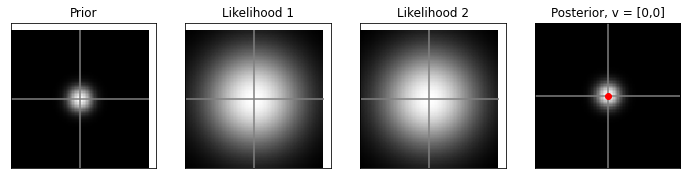

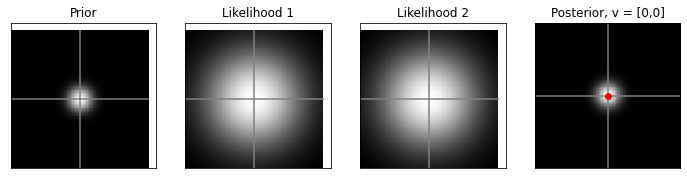

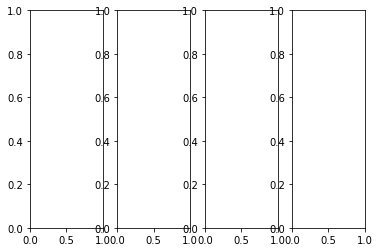

In [23]:
vx, vy = np.ogrid[-50:51,-50:51]
prior = prior1(vx, vy)   # Zero mean gaussian prior
prior.shape
sigma = 10
fig, axes = plt.subplots(1, 4)
scaler = MinMaxScaler(feature_range=(0, 255))

def plot_images(fig):
  fig.canvas.draw()
  X = np.array(fig.canvas.renderer._renderer)
  return X

# v_x_t and v_y_t will store argmax(posterior) through time
v_x_t, v_y_t = [], []
# When the stimulus is moving at a constant velocity
fig.suptitle("Before change in velocity")
posteriors = []
for i in range(10):
  fig, prior, v_x, v_y = model(prior, sigma, fig, axes)
  posteriors.append(plot_images(fig))
  fig, axes = plt.subplots(1, 4)
  v_x_t.append(v_x)
  v_y_t.append(v_y)


# After the stimulus stops moving at that velocity, the likelihood goes to Gaussian
fig.suptitle("After change in velocity")
no_velocity_prior = prior1(vx, vy)
for i in range(50):
  fig, prior, v_x, v_y = model(prior, sigma, fig, axes, change_v=True, gaussian_likelihood=True)
  prior = -200*prior/np.min(prior)  # Normalize because otherwise the max abs value runs off
  posteriors.append(plot_images(fig))
  v_x_t.append(v_x)
  v_y_t.append(v_y)
  fig, axes = plt.subplots(1, 4)

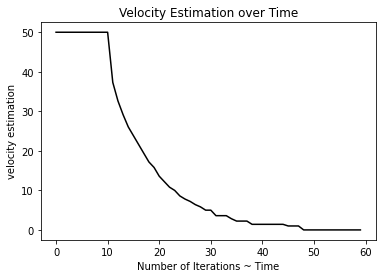

In [24]:
import math
dist = np.sqrt(np.power(v_x_t, 2) + np.power(v_y_t,2))
plt.plot(dist, color='black')
plt.xlabel("Number of Iterations ~ Time")
plt.ylabel("velocity estimation")
plt.title('Velocity Estimation over Time');

This shows the leaky-integrator behaviour of the velocity estimation from the likelihood